# Try to classify contigs as prokaryotic or eukaryotic just from an alignment

General idea: eukaryotic contigs, compared with prokaryotic contigs, should have relatively high amounts of positions with mutation frequencies around 50% (representing diploidy).

In [39]:
%run "Header.ipynb"
import os
import math
import json
import skbio
import pysam
import pysamstats
import pandas as pd
from statistics import mean
import pleuk.param_defaults as params
from pleuk.utils import get_seq2len
from pleuk.bam_utils import process_contig

## Load data: sheep gut contigs

This is obviously a very _ad hoc_ way of defining a file format. If this ever becomes a tool people use, it'd be a lot faster / more efficient to store this in a dedicated table structure!

These JSONs should already be filtered to edges with sufficient length and average coverage.

In [5]:
with open("../../prok-euk-analyses/output/pleuk_debug_info.txt", "r") as pef:
    edge2meancov = json.loads(pef.readline().strip())
    edge2num_wc_pos = json.loads(pef.readline().strip())
    edge2num_wc_diploid_pos = json.loads(pef.readline().strip())
    edge2num_wc_den_pos = json.loads(pef.readline().strip())
    
    print(f"{len(edge2meancov):,} edges in edge2meancov.")
    print(f"{len(edge2num_wc_pos):,} edges in edge2num_wc_pos.")
    print(f"{len(edge2num_wc_diploid_pos):,} edges in edge2num_wc_diploid_pos.")
    print(f"{len(edge2num_wc_den_pos):,} edges in edge2num_wc_den_pos.")

43,562 edges in edge2meancov.
12,099 edges in edge2num_wc_pos.
12,099 edges in edge2num_wc_diploid_pos.
12,099 edges in edge2num_wc_den_pos.


In [32]:
edge2len = get_seq2len("../../sheepgut/main-workflow/output/all_edges.fasta")
long_enough_seqs = [e for e in edge2len if edge2len[e] >= params.MIN_CONTIG_LEN]
print(f"{len(long_enough_seqs):,} edges with sufficient length.")

43,562 edges with sufficient length.


## Load data: contig from a human genome assembly

In [52]:
hbf = pysam.AlignmentFile("../../pleuk/misc-data/output/aln-sorted.bam", "rb")
human_contig_results = process_contig(
    "../../pleuk/misc-data/output/h1tg000001l.fasta",
    hbf,
    "h1tg000001l",
    101329166,
    params.MIN_AVG_COV,
    params.MIN_ALT_POS,
    params.WELL_COVERED_POS_DEVIATION,
    params.WELL_COVERED_POS_DEVIATION / 100,
    # The numerator / denominator stuff doesn't really matter here, since we're just extracting the
    # alt relfreqs. We thus keep them the same as the defaults for the sake of simplicity.
    params.MIN_NUMERATOR_ALT_RELFREQ / 100,
    params.MIN_DENOMINATOR_ALT_RELFREQ / 100,
    params.MAX_NUMERATOR_ALT_RELFREQ / 100,
    params.MAX_DENOMINATOR_ALT_RELFREQ / 100,
    False,
    params.PYSAM_MAX_DEPTH,
    verbose=True,
    extra_verbose=True,
    split_int_blocks=50000,
)

hbf.close()

Starting process_contig() for contig h1tg000001l.
Contig has length 101,329,166 bp. Splitting into blocks of length 50,000 bp.
Since the contig length isn't divisible by the block length, the last 29,166 bp of this contig will be ignored.
Just processed position 100,000 / 101,329,166 (0.10%).
Just processed position 200,000 / 101,329,166 (0.20%).
Just processed position 300,000 / 101,329,166 (0.30%).
Just processed position 400,000 / 101,329,166 (0.39%).
Just processed position 500,000 / 101,329,166 (0.49%).
Just processed position 600,000 / 101,329,166 (0.59%).
Just processed position 700,000 / 101,329,166 (0.69%).
Just processed position 800,000 / 101,329,166 (0.79%).
Just processed position 900,000 / 101,329,166 (0.89%).
Just processed position 1,000,000 / 101,329,166 (0.99%).
Just processed position 1,100,000 / 101,329,166 (1.09%).
Just processed position 1,200,000 / 101,329,166 (1.18%).
Just processed position 1,300,000 / 101,329,166 (1.28%).
Just processed position 1,400,000 / 10

Just processed position 14,000,000 / 101,329,166 (13.82%).
Just processed position 14,100,000 / 101,329,166 (13.92%).
Just processed position 14,200,000 / 101,329,166 (14.01%).
Just processed position 14,300,000 / 101,329,166 (14.11%).
Just processed position 14,400,000 / 101,329,166 (14.21%).
Just processed position 14,500,000 / 101,329,166 (14.31%).
Just processed position 14,600,000 / 101,329,166 (14.41%).
Just processed position 14,700,000 / 101,329,166 (14.51%).
Just processed position 14,800,000 / 101,329,166 (14.61%).
Just processed position 14,900,000 / 101,329,166 (14.70%).
Just processed position 15,000,000 / 101,329,166 (14.80%).
Just processed position 15,100,000 / 101,329,166 (14.90%).
Just processed position 15,200,000 / 101,329,166 (15.00%).
Just processed position 15,300,000 / 101,329,166 (15.10%).
Just processed position 15,400,000 / 101,329,166 (15.20%).
Just processed position 15,500,000 / 101,329,166 (15.30%).
Just processed position 15,600,000 / 101,329,166 (15.40%

Just processed position 27,900,000 / 101,329,166 (27.53%).
Just processed position 28,000,000 / 101,329,166 (27.63%).
Just processed position 28,100,000 / 101,329,166 (27.73%).
Just processed position 28,200,000 / 101,329,166 (27.83%).
Just processed position 28,300,000 / 101,329,166 (27.93%).
Just processed position 28,400,000 / 101,329,166 (28.03%).
Just processed position 28,500,000 / 101,329,166 (28.13%).
Just processed position 28,600,000 / 101,329,166 (28.22%).
Just processed position 28,700,000 / 101,329,166 (28.32%).
Just processed position 28,800,000 / 101,329,166 (28.42%).
Just processed position 28,900,000 / 101,329,166 (28.52%).
Just processed position 29,000,000 / 101,329,166 (28.62%).
Just processed position 29,100,000 / 101,329,166 (28.72%).
Just processed position 29,200,000 / 101,329,166 (28.82%).
Just processed position 29,300,000 / 101,329,166 (28.92%).
Just processed position 29,400,000 / 101,329,166 (29.01%).
Just processed position 29,500,000 / 101,329,166 (29.11%

Just processed position 41,800,000 / 101,329,166 (41.25%).
Just processed position 41,900,000 / 101,329,166 (41.35%).
Just processed position 42,000,000 / 101,329,166 (41.45%).
Just processed position 42,100,000 / 101,329,166 (41.55%).
Just processed position 42,200,000 / 101,329,166 (41.65%).
Just processed position 42,300,000 / 101,329,166 (41.75%).
Just processed position 42,400,000 / 101,329,166 (41.84%).
Just processed position 42,500,000 / 101,329,166 (41.94%).
Just processed position 42,600,000 / 101,329,166 (42.04%).
Just processed position 42,700,000 / 101,329,166 (42.14%).
Just processed position 42,800,000 / 101,329,166 (42.24%).
Just processed position 42,900,000 / 101,329,166 (42.34%).
Just processed position 43,000,000 / 101,329,166 (42.44%).
Just processed position 43,100,000 / 101,329,166 (42.53%).
Just processed position 43,200,000 / 101,329,166 (42.63%).
Just processed position 43,300,000 / 101,329,166 (42.73%).
Just processed position 43,400,000 / 101,329,166 (42.83%

Just processed position 55,700,000 / 101,329,166 (54.97%).
Just processed position 55,800,000 / 101,329,166 (55.07%).
Just processed position 55,900,000 / 101,329,166 (55.17%).
Just processed position 56,000,000 / 101,329,166 (55.27%).
Just processed position 56,100,000 / 101,329,166 (55.36%).
Just processed position 56,200,000 / 101,329,166 (55.46%).
Just processed position 56,300,000 / 101,329,166 (55.56%).
Just processed position 56,400,000 / 101,329,166 (55.66%).
Just processed position 56,500,000 / 101,329,166 (55.76%).
Just processed position 56,600,000 / 101,329,166 (55.86%).
Just processed position 56,700,000 / 101,329,166 (55.96%).
Just processed position 56,800,000 / 101,329,166 (56.05%).
Just processed position 56,900,000 / 101,329,166 (56.15%).
Just processed position 57,000,000 / 101,329,166 (56.25%).
Just processed position 57,100,000 / 101,329,166 (56.35%).
Just processed position 57,200,000 / 101,329,166 (56.45%).
Just processed position 57,300,000 / 101,329,166 (56.55%

Just processed position 69,600,000 / 101,329,166 (68.69%).
Just processed position 69,700,000 / 101,329,166 (68.79%).
Just processed position 69,800,000 / 101,329,166 (68.88%).
Just processed position 69,900,000 / 101,329,166 (68.98%).
Just processed position 70,000,000 / 101,329,166 (69.08%).
Just processed position 70,100,000 / 101,329,166 (69.18%).
Just processed position 70,200,000 / 101,329,166 (69.28%).
Just processed position 70,300,000 / 101,329,166 (69.38%).
Just processed position 70,400,000 / 101,329,166 (69.48%).
Just processed position 70,500,000 / 101,329,166 (69.58%).
Just processed position 70,600,000 / 101,329,166 (69.67%).
Just processed position 70,700,000 / 101,329,166 (69.77%).
Just processed position 70,800,000 / 101,329,166 (69.87%).
Just processed position 70,900,000 / 101,329,166 (69.97%).
Just processed position 71,000,000 / 101,329,166 (70.07%).
Just processed position 71,100,000 / 101,329,166 (70.17%).
Just processed position 71,200,000 / 101,329,166 (70.27%

Just processed position 83,500,000 / 101,329,166 (82.40%).
Just processed position 83,600,000 / 101,329,166 (82.50%).
Just processed position 83,700,000 / 101,329,166 (82.60%).
Just processed position 83,800,000 / 101,329,166 (82.70%).
Just processed position 83,900,000 / 101,329,166 (82.80%).
Just processed position 84,000,000 / 101,329,166 (82.90%).
Just processed position 84,100,000 / 101,329,166 (83.00%).
Just processed position 84,200,000 / 101,329,166 (83.10%).
Just processed position 84,300,000 / 101,329,166 (83.19%).
Just processed position 84,400,000 / 101,329,166 (83.29%).
Just processed position 84,500,000 / 101,329,166 (83.39%).
Just processed position 84,600,000 / 101,329,166 (83.49%).
Just processed position 84,700,000 / 101,329,166 (83.59%).
Just processed position 84,800,000 / 101,329,166 (83.69%).
Just processed position 84,900,000 / 101,329,166 (83.79%).
Just processed position 85,000,000 / 101,329,166 (83.89%).
Just processed position 85,100,000 / 101,329,166 (83.98%

Just processed position 97,400,000 / 101,329,166 (96.12%).
Just processed position 97,500,000 / 101,329,166 (96.22%).
Just processed position 97,600,000 / 101,329,166 (96.32%).
Just processed position 97,700,000 / 101,329,166 (96.42%).
Just processed position 97,800,000 / 101,329,166 (96.52%).
Just processed position 97,900,000 / 101,329,166 (96.62%).
Just processed position 98,000,000 / 101,329,166 (96.71%).
Just processed position 98,100,000 / 101,329,166 (96.81%).
Just processed position 98,200,000 / 101,329,166 (96.91%).
Just processed position 98,300,000 / 101,329,166 (97.01%).
Just processed position 98,400,000 / 101,329,166 (97.11%).
Just processed position 98,500,000 / 101,329,166 (97.21%).
Just processed position 98,600,000 / 101,329,166 (97.31%).
Just processed position 98,700,000 / 101,329,166 (97.41%).
Just processed position 98,800,000 / 101,329,166 (97.50%).
Just processed position 98,900,000 / 101,329,166 (97.60%).
Just processed position 99,000,000 / 101,329,166 (97.70%

    Just finished block #83 of 50,000 bp.
    Creating another block...
    Just finished block #84 of 50,000 bp.
    Creating another block...
    Just finished block #85 of 50,000 bp.
    Creating another block...
    Just finished block #86 of 50,000 bp.
    Creating another block...
    Just finished block #87 of 50,000 bp.
    Creating another block...
    Just finished block #88 of 50,000 bp.
    Creating another block...
    Just finished block #89 of 50,000 bp.
    Creating another block...
    Just finished block #90 of 50,000 bp.
    Creating another block...
    Just finished block #91 of 50,000 bp.
    Creating another block...
    Just finished block #92 of 50,000 bp.
    Creating another block...
    Just finished block #93 of 50,000 bp.
    Creating another block...
    Just finished block #94 of 50,000 bp.
    Creating another block...
    Just finished block #95 of 50,000 bp.
    Creating another block...
    Just finished block #96 of 50,000 bp.
    Creating another b

    Just finished block #201 of 50,000 bp.
    Creating another block...
    Just finished block #202 of 50,000 bp.
    Creating another block...
    Just finished block #203 of 50,000 bp.
    Creating another block...
    Just finished block #204 of 50,000 bp.
    Creating another block...
    Just finished block #205 of 50,000 bp.
    Creating another block...
    Just finished block #206 of 50,000 bp.
    Creating another block...
    Just finished block #207 of 50,000 bp.
    Creating another block...
    Just finished block #208 of 50,000 bp.
    Creating another block...
    Just finished block #209 of 50,000 bp.
    Creating another block...
    Just finished block #210 of 50,000 bp.
    Creating another block...
    Just finished block #211 of 50,000 bp.
    Creating another block...
    Just finished block #212 of 50,000 bp.
    Creating another block...
    Just finished block #213 of 50,000 bp.
    Creating another block...
    Just finished block #214 of 50,000 bp.
    Crea

    Just finished block #329 of 50,000 bp.
    Creating another block...
    Just finished block #330 of 50,000 bp.
    Creating another block...
    Just finished block #331 of 50,000 bp.
    Creating another block...
    Just finished block #332 of 50,000 bp.
    Creating another block...
    Just finished block #333 of 50,000 bp.
    Creating another block...
    Just finished block #334 of 50,000 bp.
    Creating another block...
    Just finished block #335 of 50,000 bp.
    Creating another block...
    Just finished block #336 of 50,000 bp.
    Creating another block...
    Just finished block #337 of 50,000 bp.
    Creating another block...
    Just finished block #338 of 50,000 bp.
    Creating another block...
    Just finished block #339 of 50,000 bp.
    Creating another block...
    Just finished block #340 of 50,000 bp.
    Creating another block...
    Just finished block #341 of 50,000 bp.
    Creating another block...
    Just finished block #342 of 50,000 bp.
    Crea

    Just finished block #450 of 50,000 bp.
    Creating another block...
    Just finished block #451 of 50,000 bp.
    Creating another block...
    Just finished block #452 of 50,000 bp.
    Creating another block...
    Just finished block #453 of 50,000 bp.
    Creating another block...
    Just finished block #454 of 50,000 bp.
    Creating another block...
    Just finished block #455 of 50,000 bp.
    Creating another block...
    Just finished block #456 of 50,000 bp.
    Creating another block...
    Just finished block #457 of 50,000 bp.
    Creating another block...
    Just finished block #458 of 50,000 bp.
    Creating another block...
    Just finished block #459 of 50,000 bp.
    Creating another block...
    Just finished block #460 of 50,000 bp.
    Creating another block...
    Just finished block #461 of 50,000 bp.
    Creating another block...
    Just finished block #462 of 50,000 bp.
    Creating another block...
    Just finished block #463 of 50,000 bp.
    Crea

    Just finished block #575 of 50,000 bp.
    Creating another block...
    Just finished block #576 of 50,000 bp.
    Creating another block...
    Just finished block #577 of 50,000 bp.
    Creating another block...
    Just finished block #578 of 50,000 bp.
    Creating another block...
    Just finished block #579 of 50,000 bp.
    Creating another block...
    Just finished block #580 of 50,000 bp.
    Creating another block...
    Just finished block #581 of 50,000 bp.
    Creating another block...
    Just finished block #582 of 50,000 bp.
    Creating another block...
    Just finished block #583 of 50,000 bp.
    Creating another block...
    Just finished block #584 of 50,000 bp.
    Creating another block...
    Just finished block #585 of 50,000 bp.
    Creating another block...
    Just finished block #586 of 50,000 bp.
    Creating another block...
    Just finished block #587 of 50,000 bp.
    Creating another block...
    Just finished block #588 of 50,000 bp.
    Crea

    Just finished block #703 of 50,000 bp.
    Creating another block...
    Just finished block #704 of 50,000 bp.
    Creating another block...
    Just finished block #705 of 50,000 bp.
    Creating another block...
    Just finished block #706 of 50,000 bp.
    Creating another block...
    Just finished block #707 of 50,000 bp.
    Creating another block...
    Just finished block #708 of 50,000 bp.
    Creating another block...
    Just finished block #709 of 50,000 bp.
    Creating another block...
    Just finished block #710 of 50,000 bp.
    Creating another block...
    Just finished block #711 of 50,000 bp.
    Creating another block...
    Just finished block #712 of 50,000 bp.
    Creating another block...
    Just finished block #713 of 50,000 bp.
    Creating another block...
    Just finished block #714 of 50,000 bp.
    Creating another block...
    Just finished block #715 of 50,000 bp.
    Creating another block...
    Just finished block #716 of 50,000 bp.
    Crea

    Just finished block #826 of 50,000 bp.
    Creating another block...
    Just finished block #827 of 50,000 bp.
    Creating another block...
    Just finished block #828 of 50,000 bp.
    Creating another block...
    Just finished block #829 of 50,000 bp.
    Creating another block...
    Just finished block #830 of 50,000 bp.
    Creating another block...
    Just finished block #831 of 50,000 bp.
    Creating another block...
    Just finished block #832 of 50,000 bp.
    Creating another block...
    Just finished block #833 of 50,000 bp.
    Creating another block...
    Just finished block #834 of 50,000 bp.
    Creating another block...
    Just finished block #835 of 50,000 bp.
    Creating another block...
    Just finished block #836 of 50,000 bp.
    Creating another block...
    Just finished block #837 of 50,000 bp.
    Creating another block...
    Just finished block #838 of 50,000 bp.
    Creating another block...
    Just finished block #839 of 50,000 bp.
    Crea

    Just finished block #954 of 50,000 bp.
    Creating another block...
    Just finished block #955 of 50,000 bp.
    Creating another block...
    Just finished block #956 of 50,000 bp.
    Creating another block...
    Just finished block #957 of 50,000 bp.
    Creating another block...
    Just finished block #958 of 50,000 bp.
    Creating another block...
    Just finished block #959 of 50,000 bp.
    Creating another block...
    Just finished block #960 of 50,000 bp.
    Creating another block...
    Just finished block #961 of 50,000 bp.
    Creating another block...
    Just finished block #962 of 50,000 bp.
    Creating another block...
    Just finished block #963 of 50,000 bp.
    Creating another block...
    Just finished block #964 of 50,000 bp.
    Creating another block...
    Just finished block #965 of 50,000 bp.
    Creating another block...
    Just finished block #966 of 50,000 bp.
    Creating another block...
    Just finished block #967 of 50,000 bp.
    Crea

    Just finished block #1,082 of 50,000 bp.
    Creating another block...
    Just finished block #1,083 of 50,000 bp.
    Creating another block...
    Just finished block #1,084 of 50,000 bp.
    Creating another block...
    Just finished block #1,085 of 50,000 bp.
    Creating another block...
    Just finished block #1,086 of 50,000 bp.
    Creating another block...
    Just finished block #1,087 of 50,000 bp.
    Creating another block...
    Just finished block #1,088 of 50,000 bp.
    Creating another block...
    Just finished block #1,089 of 50,000 bp.
    Creating another block...
    Just finished block #1,090 of 50,000 bp.
    Creating another block...
    Just finished block #1,091 of 50,000 bp.
    Creating another block...
    Just finished block #1,092 of 50,000 bp.
    Creating another block...
    Just finished block #1,093 of 50,000 bp.
    Creating another block...
    Just finished block #1,094 of 50,000 bp.
    Creating another block...
    Just finished block #

    Just finished block #1,213 of 50,000 bp.
    Creating another block...
    Just finished block #1,214 of 50,000 bp.
    Creating another block...
    Just finished block #1,215 of 50,000 bp.
    Creating another block...
    Just finished block #1,216 of 50,000 bp.
    Creating another block...
    Just finished block #1,217 of 50,000 bp.
    Creating another block...
    Just finished block #1,218 of 50,000 bp.
    Creating another block...
    Just finished block #1,219 of 50,000 bp.
    Creating another block...
    Just finished block #1,220 of 50,000 bp.
    Creating another block...
    Just finished block #1,221 of 50,000 bp.
    Creating another block...
    Just finished block #1,222 of 50,000 bp.
    Creating another block...
    Just finished block #1,223 of 50,000 bp.
    Creating another block...
    Just finished block #1,224 of 50,000 bp.
    Creating another block...
    Just finished block #1,225 of 50,000 bp.
    Creating another block...
    Just finished block #

    Just finished block #1,336 of 50,000 bp.
    Creating another block...
    Just finished block #1,337 of 50,000 bp.
    Creating another block...
    Just finished block #1,338 of 50,000 bp.
    Creating another block...
    Just finished block #1,339 of 50,000 bp.
    Creating another block...
    Just finished block #1,340 of 50,000 bp.
    Creating another block...
    Just finished block #1,341 of 50,000 bp.
    Creating another block...
    Just finished block #1,342 of 50,000 bp.
    Creating another block...
    Just finished block #1,343 of 50,000 bp.
    Creating another block...
    Just finished block #1,344 of 50,000 bp.
    Creating another block...
    Just finished block #1,345 of 50,000 bp.
    Creating another block...
    Just finished block #1,346 of 50,000 bp.
    Creating another block...
    Just finished block #1,347 of 50,000 bp.
    Creating another block...
    Just finished block #1,348 of 50,000 bp.
    Creating another block...
    Just finished block #

    Just finished block #1,461 of 50,000 bp.
    Creating another block...
    Just finished block #1,462 of 50,000 bp.
    Creating another block...
    Just finished block #1,463 of 50,000 bp.
    Creating another block...
    Just finished block #1,464 of 50,000 bp.
    Creating another block...
    Just finished block #1,465 of 50,000 bp.
    Creating another block...
    Just finished block #1,466 of 50,000 bp.
    Creating another block...
    Just finished block #1,467 of 50,000 bp.
    Creating another block...
    Just finished block #1,468 of 50,000 bp.
    Creating another block...
    Just finished block #1,469 of 50,000 bp.
    Creating another block...
    Just finished block #1,470 of 50,000 bp.
    Creating another block...
    Just finished block #1,471 of 50,000 bp.
    Creating another block...
    Just finished block #1,472 of 50,000 bp.
    Creating another block...
    Just finished block #1,473 of 50,000 bp.
    Creating another block...
    Just finished block #

    Just finished block #1,584 of 50,000 bp.
    Creating another block...
    Just finished block #1,585 of 50,000 bp.
    Creating another block...
    Just finished block #1,586 of 50,000 bp.
    Creating another block...
    Just finished block #1,587 of 50,000 bp.
    Creating another block...
    Just finished block #1,588 of 50,000 bp.
    Creating another block...
    Just finished block #1,589 of 50,000 bp.
    Creating another block...
    Just finished block #1,590 of 50,000 bp.
    Creating another block...
    Just finished block #1,591 of 50,000 bp.
    Creating another block...
    Just finished block #1,592 of 50,000 bp.
    Creating another block...
    Just finished block #1,593 of 50,000 bp.
    Creating another block...
    Just finished block #1,594 of 50,000 bp.
    Creating another block...
    Just finished block #1,595 of 50,000 bp.
    Creating another block...
    Just finished block #1,596 of 50,000 bp.
    Creating another block...
    Just finished block #

    Just finished block #1,709 of 50,000 bp.
    Creating another block...
    Just finished block #1,710 of 50,000 bp.
    Creating another block...
    Just finished block #1,711 of 50,000 bp.
    Creating another block...
    Just finished block #1,712 of 50,000 bp.
    Creating another block...
    Just finished block #1,713 of 50,000 bp.
    Creating another block...
    Just finished block #1,714 of 50,000 bp.
    Creating another block...
    Just finished block #1,715 of 50,000 bp.
    Creating another block...
    Just finished block #1,716 of 50,000 bp.
    Creating another block...
    Just finished block #1,717 of 50,000 bp.
    Creating another block...
    Just finished block #1,718 of 50,000 bp.
    Creating another block...
    Just finished block #1,719 of 50,000 bp.
    Creating another block...
    Just finished block #1,720 of 50,000 bp.
    Creating another block...
    Just finished block #1,721 of 50,000 bp.
    Creating another block...
    Just finished block #

    Just finished block #1,836 of 50,000 bp.
    Creating another block...
    Just finished block #1,837 of 50,000 bp.
    Creating another block...
    Just finished block #1,838 of 50,000 bp.
    Creating another block...
    Just finished block #1,839 of 50,000 bp.
    Creating another block...
    Just finished block #1,840 of 50,000 bp.
    Creating another block...
    Just finished block #1,841 of 50,000 bp.
    Creating another block...
    Just finished block #1,842 of 50,000 bp.
    Creating another block...
    Just finished block #1,843 of 50,000 bp.
    Creating another block...
    Just finished block #1,844 of 50,000 bp.
    Creating another block...
    Just finished block #1,845 of 50,000 bp.
    Creating another block...
    Just finished block #1,846 of 50,000 bp.
    Creating another block...
    Just finished block #1,847 of 50,000 bp.
    Creating another block...
    Just finished block #1,848 of 50,000 bp.
    Creating another block...
    Just finished block #

    Just finished block #1,946 of 50,000 bp.
    Creating another block...
    Just finished block #1,947 of 50,000 bp.
    Creating another block...
    Just finished block #1,948 of 50,000 bp.
    Creating another block...
    Just finished block #1,949 of 50,000 bp.
    Creating another block...
    Just finished block #1,950 of 50,000 bp.
    Creating another block...
    Just finished block #1,951 of 50,000 bp.
    Creating another block...
    Just finished block #1,952 of 50,000 bp.
    Creating another block...
    Just finished block #1,953 of 50,000 bp.
    Creating another block...
    Just finished block #1,954 of 50,000 bp.
    Creating another block...
    Just finished block #1,955 of 50,000 bp.
    Creating another block...
    Just finished block #1,956 of 50,000 bp.
    Creating another block...
    Just finished block #1,957 of 50,000 bp.
    Creating another block...
    Just finished block #1,958 of 50,000 bp.
    Creating another block...
    Just finished block #

In [138]:
print(
    "Considering ALL positions in the human genome contig, its average coverage is "
    f"{human_contig_results['avg_cov']:,.2f}x."
)

Considering ALL positions in the human genome contig, its average coverage is 38.49x.


In [75]:
num_human_blocks = len(human_contig_results["num_wc_pos"])
print(f"{num_human_blocks:,} blocks.")

# ignoging the first and last 20 blocks corresponds to ignoring the first and last 1,000,000 bp, since blocks are
# 50,000 bp long. This is actually a bit more overzealous than that on the end since we're already ignoring ~29 kbp
# due to it not fitting into a block, but that's fine.
NUM_SIDE_BLOCKS_TO_IGNORE = 20
inner_block_start_idx = NUM_SIDE_BLOCKS_TO_IGNORE
inner_block_end_idx = num_human_blocks - NUM_SIDE_BLOCKS_TO_IGNORE
print(f"Ignoring the first and last {NUM_SIDE_BLOCKS_TO_IGNORE:,} blocks.")
num_inner_blocks = num_human_blocks - (NUM_SIDE_BLOCKS_TO_IGNORE * 2)
print(f"There are thus {num_inner_blocks:,} blocks.")

# verify i didn't mess something up (look it's 1:39am right now i am so tired)
assert len(human_contig_results["num_wc_pos"][inner_block_start_idx : inner_block_end_idx]) == num_inner_blocks

2,026 blocks.
Ignoring the first and last 20 blocks.
There are thus 1,986 blocks.


In [6]:
# NOTE: This is a huge file, if this needs to be adapted into a pipeline or something this should be modified
# so that the file is read line-by-line or something rather than all at once
with open(os.path.join(PE_OUT_DIR, "h1tg000001l-mincov-pos-mutation-rates.json"), "r") as hf:
    h_mut_rates = json.load(hf)["h1tg000001l"]
    
print(f"There are {len(h_mut_rates):,} positions described in this file.")

There are 87,940,234 positions described in this file.


In [7]:
num_wc_pos = len(h_mut_rates)
# the 2e6 accounts for the positions we sliced off
num_total_pos = len(skbio.DNA.read(os.path.join(PE_OUT_DIR, "h1tg000001l.fasta"))) - int(2e6)
human_wc_frac = num_wc_pos / num_total_pos
print(f"Human contig region has {num_wc_pos:,} WC pos, and {num_total_pos:,} total pos.")
print(f"Therefore, fraction of WC pos to total pos is {human_wc_frac * 100:.2f}%.")

Human contig region has 87,940,234 WC pos, and 99,329,166 total pos.
Therefore, fraction of WC pos to total pos is 88.53%.


## Utility functions for showing histograms

`fracplot` is useful for showing histograms of edge "fractions" of some sort, where each edge has an associated fraction.

`seq_mutrate_hist` is useful for showing histograms of positions' mutation rates.

In [16]:
def fracplot(
    edge2frac,
    numerator_desc,
    denominator_desc,
    noun="sheep gut contigs with length $\geq$ 5,000 bp",
    denclause="\nand a nonzero denominator",
    xlabel="Fraction of 'diploid' positions (%)",
    ylabel="Number of contigs with fractions in a range",
    use_symlog=True,
    bar_interior_color="#660066",
    bar_exterior_color="#220022",
    vlines=[],
    figfilename=None
):
    """Utility function to make it easy to draw these histograms of fractions.
    
    A lot of the code here is yanked from the diversity index notebook I wrote.
    """
    fig, ax = pyplot.subplots(1)
    num_edges = len(edge2frac)
    print(f"{num_edges:,} edges represented in this edge2frac object.")
    fracs = [100 * v for v in edge2frac.values()]
    
    # For reference, print info about extreme edge values, for help with sanity-checking
    # The key=edge2frac.get thing lets us essentially just do argmax: https://stackoverflow.com/a/280156
    sorted_edges = sorted(edge2frac.keys(), key=edge2frac.get)
    max_edge = sorted_edges[-1]
    min_edge = sorted_edges[0]
    print(f"Max frac: {max(fracs)} (edge {max_edge}); min frac: {min(fracs)} (edge {min_edge})")
    N = 10
    print(f"Top {N} edges: {sorted_edges[-N:]}")
    print(f"Bottom {N} edges: {sorted_edges[:N]}")
    
    # Possible to allow this to be reduced, but currently we only need 100% max here
    #xlim_max = math.ceil(max(fracs))
    xlim_max = 100
    bins = range(xlim_max + 1)
    ax.hist(
        fracs, 
        color=bar_interior_color,
        linewidth=1,
        edgecolor=bar_exterior_color,
        bins=bins
    )
    if xlim_max < 20:
        ax.set_xticks(bins)
    else:
        ax.set_xticks(range(0, xlim_max + 1, 10))
    if use_symlog:
        ax.set_yscale("symlog")
        
    ax.set_xlim(0, xlim_max)
    
    for vline_info in vlines:
        ax.axvline(vline_info[0] * 100, label=vline_info[1], color="#ee0000", linestyle=":")
        
    if len(vlines) > 0:
        ax.legend()
        
    # Don't write the axis numbers as 10^0, 10^1, etc. -- just write as 1, 10, etc.
    # https://stackoverflow.com/a/49751075
    ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())

    use_thousands_sep(ax.yaxis)

    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_title(
        f"Histogram of {num_edges:,} {noun}{denclause}:\n" +
        r"$\frac{\mathrm{" + numerator_desc + "}}{\mathrm{" + denominator_desc + "}}$",
        fontsize=18
    )
    fig.set_size_inches(10, 5)
    if figfilename is not None:
        fig.savefig(f"figs/{figfilename}", bbox_inches="tight")

In [92]:
def seq_mutrate_hist(ax, mut_rates, x2vlinecolor={40: "#8888dd"}, linewidth=1, extra_check=True, use_symlog=True):
    """Actually visualizes a histogram of mutation rates for a given sequence.
    
    ax should be a matplotlib Axes object -- the plot will be drawn here (useful if we wanna draw
    a bunch of these plots in the same Figure).
    
    mut_rates should contain numbers in the range [0, 0.5]. These'll be automatically converted to percentages.
    """
    if extra_check:
        for f in mut_rates:
            assert f <= 0.5
    binsize = 1
    # one bin per (binsize) percent, aka 1% right now. this is important, please don't change that future marcus.
    #
    # per matplotlib hist defaults (i think i've documented this like 10 times throughout this project lol),
    # bins are set up so that it's [0%, 1%), [1%, 2%), ..., [48%, 49%), [49%, 50%]. That is, the rightmost
    # bin (49 to 50%) is special in that it is inclusive on both ends instead of just the left end. This is
    # important to keep track of -- if we mess this up then mutation rates of exactly 50% get sorted into a
    # bin of [50%, 51%) or something which isn't displayed when we set the xlim to 50!!!!!!!
    bins = range(0, 51, binsize)
    _, _, patches = ax.hist(
        [f * 100 for f in mut_rates],
        bins=bins,
        color="#660066",
        linewidth=linewidth,
        edgecolor="#220022",
    )
    ax.set_ylim(0)
    ax.set_xlim(0, 50)
    if use_symlog:
        ax.set_yscale("symlog") 
    use_thousands_sep(ax.yaxis)

    for x in x2vlinecolor:
        ax.axvline(x, color=x2vlinecolor[x], linestyle="--")

    # Make bins >= 40% a different color: https://stackoverflow.com/a/49290555
    for patch in patches[40:]:
        patch.set_facecolor("#8888dd")

## Histogram of fraction of well-covered positions to total positions for certain contigs

- Sheep gut contigs with length ≥ min len, and coverage ≥ min cov
- Human contig (just the interior region)

In [18]:
# Compute this fraction for each sheepgut contig
e2wcfrac = {e: edge2num_wc_pos[e] / edge2len[e] for e in edge2num_wc_pos}
# Average the fractions across all sheepgut contigs shown here; used in the report
print(f"Average well-covered position fraction from the {len(e2wcfrac):,} edges shown in this plot: {100 * mean(e2wcfrac.values()):.2f}%")

Average well-covered position fraction from the 12,099 edges shown in this plot: 42.60%


12,099 edges represented in this edge2frac object.
Max frac: 100.0 (edge edge_78787); min frac: 0.0 (edge edge_14691)
Top 10 edges: ['edge_77449', 'edge_77458', 'edge_77530', 'edge_77774', 'edge_77894', 'edge_78010', 'edge_78293', 'edge_78765', 'edge_78778', 'edge_78787']
Bottom 10 edges: ['edge_14691', 'edge_24685', 'edge_28310', 'edge_31976', 'edge_42553', 'edge_45833', 'edge_62816', 'edge_67733', 'edge_11294', 'edge_59913']


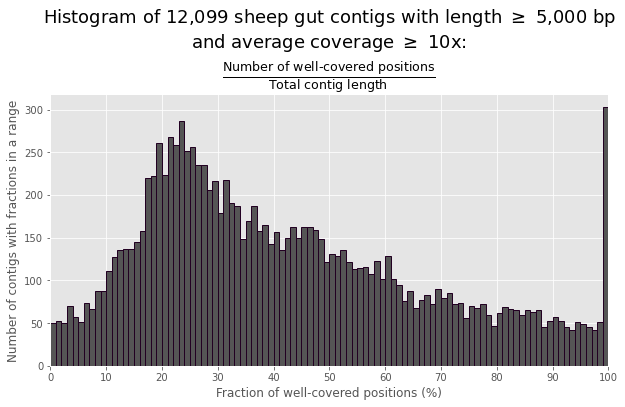

In [19]:
fracplot(
    e2wcfrac,
    r"Number\ of\ well" + u"\u2010" + r"covered\ positions",
    r"Total\ contig\ length",
    denclause=f"\nand average coverage $\geq$ {params.MIN_AVG_COV}x",
    xlabel="Fraction of well-covered positions (%)",
    figfilename="prokeuk_wcposfrac.png",
    bar_interior_color="#555555",
    #vlines=[(human_wc_frac, "Human genome contig (interior region)")],
    use_symlog=0
)

In [77]:
# Compute this fraction for the human genome blocks, ignoring first and last 20 blocks
blockidx2wcfrac = {i: human_contig_results["num_wc_pos"][i] / 50000 for i in range(inner_block_start_idx, inner_block_end_idx)}
print(f"Average WC position fraction from the {num_inner_blocks:,} blocks shown in this plot: {100 * mean(blockidx2wcfrac.values()):.2f}%")

Average WC position fraction from the 1,986 blocks shown in this plot: 76.27%


1,986 edges represented in this edge2frac object.
Max frac: 99.994 (edge 1497); min frac: 5.303999999999999 (edge 1436)
Top 10 edges: [475, 375, 304, 1839, 329, 162, 1602, 937, 790, 1497]
Bottom 10 edges: [1436, 1780, 1773, 1934, 1967, 1176, 777, 1781, 294, 240]


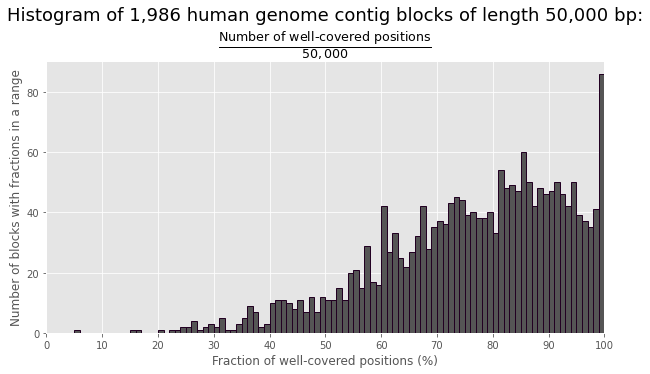

In [90]:
fracplot(
    blockidx2wcfrac,
    r"Number\ of\ well" + u"\u2010" + r"covered\ positions",
    r"50,000",
    noun="human genome contig blocks of length 50,000 bp",
    denclause="",
    xlabel="Fraction of well-covered positions (%)",
    ylabel="Number of blocks with fractions in a range",
    figfilename="prokeuk_wcposfrac_human.png",
    bar_interior_color="#555555",
    use_symlog=0
)

## Histograms of mutation frequencies (one histogram per contig)

### Human contig

In [92]:
h_mut_rates_alt_gt_min = []
for i in range(inner_block_start_idx, inner_block_end_idx):
    h_mut_rates_alt_gt_min += human_contig_results["alt_relfreqs"][i]
print(len(h_mut_rates_alt_gt_min))

92389


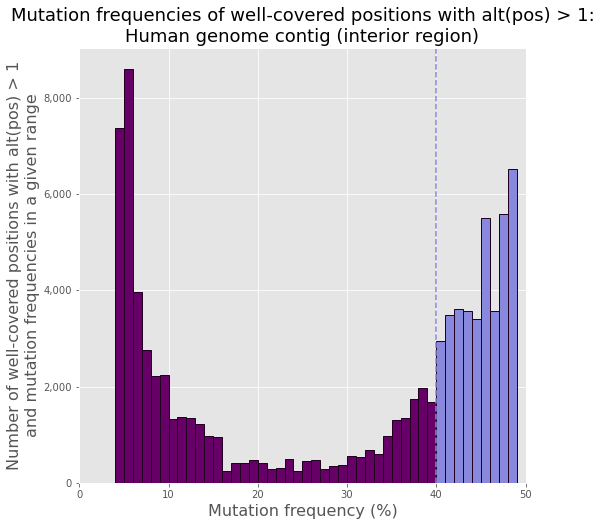

In [93]:
fig, ax = pyplot.subplots(1)

seq_mutrate_hist(ax, h_mut_rates_alt_gt_min, use_symlog=False)
ax.set_title(f"Mutation frequencies of well-covered positions with alt(pos) > 1:\nHuman genome contig (interior region)", fontsize=18)
ax.set_xlabel("Mutation frequency (%)", fontsize=16)
ax.set_ylabel(f"Number of well-covered positions with alt(pos) > 1\nand mutation frequencies in a given range", fontsize=16)

fig.set_size_inches(8, 8)
fig.savefig("figs/prokeuk_hcontig_mutrate_histogram.png", bbox_inches="tight")

### Sheep gut contigs

In [20]:
# Three selected bacterial MAGs used in the rare mutation report, plus two edges with low (or zero) fractions
#probs_prok_seqs_to_check = ["edge_6104", "edge_1671", "edge_2358", "edge_8", "edge_5763"]
probs_prok_seqs_to_check = ["edge_1", "edge_8", "edge_10", "edge_5763", "edge_25347"]
# Some edges with esp high fractions
probs_euk_seqs_to_check = ["edge_4371", "edge_26085", "edge_32274", "edge_38957", "edge_78779"]

In [45]:
def get_seq2mincov_pos_mutation_rates(seqs_to_check):
    bf = pysam.AlignmentFile("../main-workflow/output/fully-filtered-and-sorted-aln.bam")

    seq2mincov_pos_mutation_rates = {}
    for seq in seqs_to_check:
        contig_results = process_contig(
            "../main-workflow/output/all_edges.fasta",
            bf,
            seq,
            edge2len[seq],
            params.MIN_AVG_COV,
            params.MIN_ALT_POS,
            params.WELL_COVERED_POS_DEVIATION,
            params.WELL_COVERED_POS_DEVIATION / 100,
            # The numerator / denominator stuff doesn't really matter here, since we're just extracting the
            # alt relfreqs. We thus keep them the same as the defaults for the sake of simplicity.
            params.MIN_NUMERATOR_ALT_RELFREQ / 100,
            params.MIN_DENOMINATOR_ALT_RELFREQ / 100,
            params.MAX_NUMERATOR_ALT_RELFREQ / 100,
            params.MAX_DENOMINATOR_ALT_RELFREQ / 100,
            False,
            params.PYSAM_MAX_DEPTH,
            verbose=True,
            extra_verbose=True
        )
        seq2mincov_pos_mutation_rates[seq] = contig_results["alt_relfreqs"]
        print(f"Computed info for seq {seq}!")
    bf.close()
    return seq2mincov_pos_mutation_rates

In [46]:
seq2mincov_pos_mutation_rates_ten = get_seq2mincov_pos_mutation_rates(
    probs_euk_seqs_to_check + probs_prok_seqs_to_check
)

Starting process_contig() for contig edge_4371.
Just processed position 100,000 / 1,389,684 (7.20%).
Just processed position 200,000 / 1,389,684 (14.39%).
Just processed position 300,000 / 1,389,684 (21.59%).
Just processed position 400,000 / 1,389,684 (28.78%).
Just processed position 500,000 / 1,389,684 (35.98%).
Just processed position 600,000 / 1,389,684 (43.18%).
Just processed position 700,000 / 1,389,684 (50.37%).
Just processed position 800,000 / 1,389,684 (57.57%).
Just processed position 900,000 / 1,389,684 (64.76%).
Just processed position 1,000,000 / 1,389,684 (71.96%).
Just processed position 1,100,000 / 1,389,684 (79.15%).
Just processed position 1,200,000 / 1,389,684 (86.35%).
Just processed position 1,300,000 / 1,389,684 (93.55%).
    Average coverage: 12.17x. Meets the mininum of 10.00x.
    Deviation is 20.00%: coverages in the range [9.73x, 14.60x] are WC.
    406,357 / 1,389,684 (29.24%) positions in this contig are WC.
    2,325 WC numerator pos; 9,000 WC denominat

#### Save this JSON data to a new file / Load it from that file so we can avoid redoing the above step if needed

(...because this data takes like 30 minutes to generate, and I don't want to have to melt an iceberg every time I want to change a color in one of these plots...)

In [48]:
with open("misc-output/seq2mincov_pos_mutation_rates.json", "w") as jf:
    jf.write(json.dumps(seq2mincov_pos_mutation_rates_ten))

In [36]:
with open("misc-output/seq2mincov_pos_mutation_rates.json", "r") as jf:
    seq2mincov_pos_mutation_rates_ten = json.load(jf)

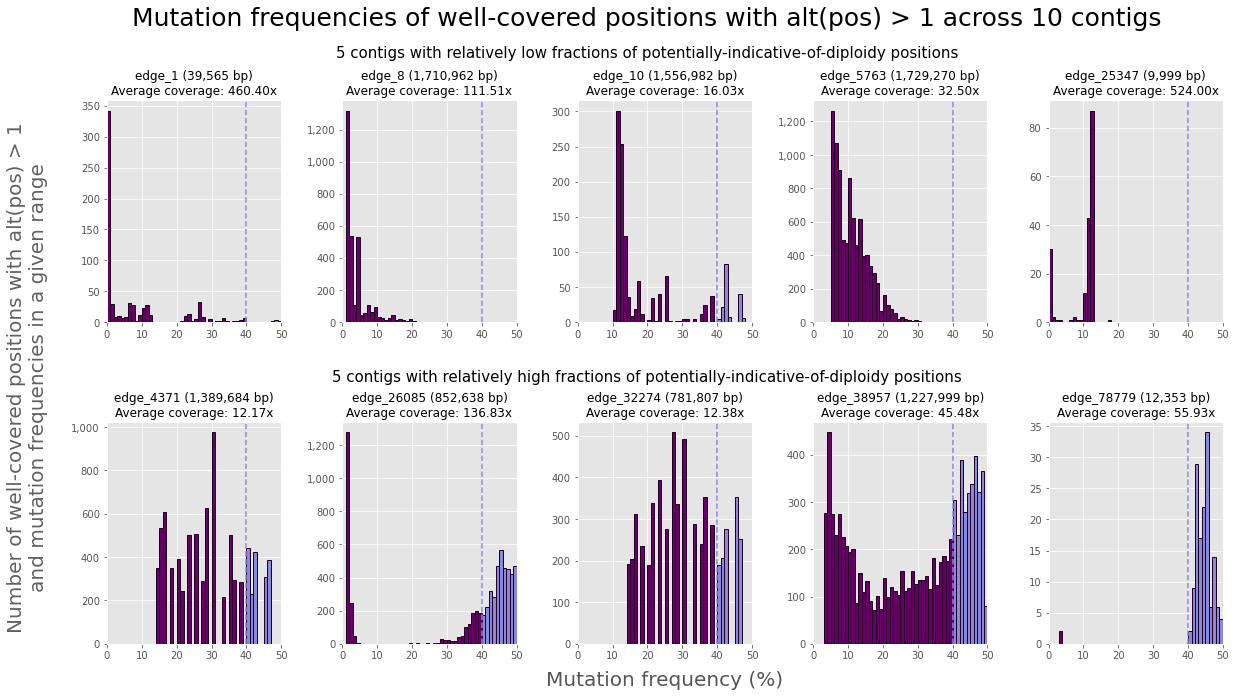

In [37]:
fig, axes = pyplot.subplots(2, 5, gridspec_kw={"wspace": 0.35, "hspace": 0.45})

rows = [probs_prok_seqs_to_check, probs_euk_seqs_to_check]
for ri, row in enumerate(rows):
    for ci, seq in enumerate(row):
        mut_rates = seq2mincov_pos_mutation_rates_ten[seq]
        seq_mutrate_hist(axes[ri, ci], mut_rates, use_symlog=False)
        axes[ri, ci].set_title(f"{seq} ({edge2len[seq]:,} bp)\nAverage coverage: {edge2meancov[seq]:,.2f}x", fontsize=12)

axes[1, 2].set_xlabel("Mutation frequency (%)", fontsize=20, labelpad=10)
        
num_plotted_edges = sum([len(r) for r in rows])
# We move up the suptitle's y from 0.98 (default) as a very crude way to force the plot to have
# more space between this title and the row 1 title.
fig.suptitle(
    f"Mutation frequencies of well-covered positions with alt(pos) > 1 across {num_plotted_edges} contigs",
    y=1.01,
    fontsize=25
)

# y-axis label: centered on the left side of the figure
fig.text(
    0.07, 0.495,
    f"Number of well-covered positions with alt(pos) > 1\nand mutation frequencies in a given range",
    color="#606060",
    fontsize=20,
    rotation=90,
    va="center",
    ha="center"
)
# Title for row 1. The y-value here is because this is figure coordinates, so this is "close to the top
# of the plot".
fig.text(
    0.5, 0.945,
    '5 contigs with relatively low fractions of potentially-indicative-of-diploidy positions',
    fontsize=15,
    ha="center",
    va="center"
)
# Title for row 2.
fig.text(
    0.5, 0.495,
    '5 contigs with relatively high fractions of potentially-indicative-of-diploidy positions',
    fontsize=15,
    ha="center",
    va="center"
)
fig.set_size_inches(20, 10)
fig.savefig("figs/prokeuk_10_mutrate_histograms.png", bbox_inches="tight")

In [113]:
def big_mr_plot(sorted_df, high_ratio_contigs, seq2mrs, L, figfilename,
                x2vlinecolor={20: "#660066", 40: "#8888dd"},
                num_range="[40%, 50%]", den_range="[20%, 40%)"):
    
    num_plotted_edges = L * L
    fig, axes = pyplot.subplots(L, L, gridspec_kw={"wspace": 0.35, "hspace": 0.6})

    for si, seq in enumerate(high_ratio_contigs[:num_plotted_edges]):
        ri = math.floor(si / L)
        ci = si % L
        mut_rates = seq2mrs[seq]
        seq_mutrate_hist(
            axes[ri, ci], mut_rates, use_symlog=False, x2vlinecolor=x2vlinecolor
        )

        # Lots of these ratios will be integers (i.e. numerator is divisible by denominator), and in these cases
        # we wanna avoid unneeded trailing zeroes. But this is not guaranteed to be the case.
        # Lots of hacks we could use here (see answers to https://stackoverflow.com/q/2440692), but we just
        # do something silly -- we have access to both the numerator and denominator of the ratio, so we can
        # show it as an integer if num % den == 0 (i.e. there's no stuff after the decimal point) and otherwise
        # use two digits.
        num = sorted_df['NumWellCoveredNumeratorPositions'][seq]
        den = sorted_df['NumWellCoveredDenominatorPositions'][seq]
        frac = sorted_df['DiploidFraction'][seq]
        if num % den == 0:
            sfrac = f"{frac:,.0f}"
        else:
            sfrac = f"{frac:,.2f}"
        axes[ri, ci].set_title(
            (
                f"{seq} ({edge2len[seq]:,} bp)\n"
                f"Average coverage: {edge2meancov[seq]:,.2f}x\n"
                f"Ratio: {num:,} / {den:,}"
                r" = "
                f"{sfrac}"
            ), fontsize=11)

    axes[L - 1, round(L / 2)].set_xlabel("Mutation frequency (%)", fontsize=20, labelpad=10)
    fig.suptitle(
        (
            f"Mutation frequencies of well-covered positions with alt(pos) > 1 across {num_plotted_edges} contigs\n"
            f"Sorted in descending order by the ratio of {num_range} mutations to {den_range} mutations"
        ),
        y=0.95,
        x=0.51,
        fontsize=35
    )

    # y-axis label: centered on the left side of the figure
    fig.text(
        0.09, 0.495,
        f"Number of well-covered positions with alt(pos) > 1\nand mutation frequencies in a given range",
        color="#606060",
        fontsize=20,
        rotation=90,
        va="center",
        ha="center"
    )
    fig.set_size_inches(30, 30)
    fig.savefig(f"figs/{figfilename}", bbox_inches="tight")

#### Contigs with high ratios of $[40\%, 50\%]$ positions to $[20\%, 40\%)$ positions

In [104]:
df = pd.read_csv("../../prok-euk-analyses/output/pleuk_diff_ratio_frac_info.tsv", sep="\t", index_col=0)
sdf = df.sort_values(by="DiploidFraction", ascending=False)
high_ratio_contigs = sdf.index[:100]

In [70]:
seq2mincov_pos_mutation_rates_ratiohigh = get_seq2mincov_pos_mutation_rates(
    high_ratio_contigs
)

Starting process_contig() for contig edge_75639.
    Average coverage: 156.07x. Meets the mininum of 10.00x.
    Deviation is 20.00%: coverages in the range [124.86x, 187.29x] are WC.
    71,529 / 82,340 (86.87%) positions in this contig are WC.
    700 WC numerator pos; 701 WC denominator pos.
Computed info for seq edge_75639!
Starting process_contig() for contig edge_68306.
    Average coverage: 11.74x. Meets the mininum of 10.00x.
    Deviation is 20.00%: coverages in the range [9.39x, 14.09x] are WC.
    6,097 / 36,395 (16.75%) positions in this contig are WC.
    138 WC numerator pos; 139 WC denominator pos.
Computed info for seq edge_68306!
Starting process_contig() for contig edge_12447.
    Average coverage: 10.66x. Meets the mininum of 10.00x.
    Deviation is 20.00%: coverages in the range [8.53x, 12.79x] are WC.
    3,195 / 12,211 (26.16%) positions in this contig are WC.
    131 WC numerator pos; 132 WC denominator pos.
Computed info for seq edge_12447!
Starting process_con

Just processed position 2,500,000 / 2,655,168 (94.16%).
Just processed position 2,600,000 / 2,655,168 (97.92%).
    Average coverage: 18.96x. Meets the mininum of 10.00x.
    Deviation is 20.00%: coverages in the range [15.17x, 22.76x] are WC.
    75,493 / 2,655,168 (2.84%) positions in this contig are WC.
    45 WC numerator pos; 49 WC denominator pos.
Computed info for seq edge_2031!
Starting process_contig() for contig edge_2470.
Just processed position 100,000 / 374,935 (26.67%).
Just processed position 200,000 / 374,935 (53.34%).
Just processed position 300,000 / 374,935 (80.01%).
    Average coverage: 17.99x. Meets the mininum of 10.00x.
    Deviation is 20.00%: coverages in the range [14.39x, 21.58x] are WC.
    1,724 / 374,935 (0.46%) positions in this contig are WC.
    134 WC numerator pos; 139 WC denominator pos.
Computed info for seq edge_2470!
Starting process_contig() for contig edge_37577.
    Average coverage: 10.13x. Meets the mininum of 10.00x.
    Deviation is 20.00%

    Average coverage: 123.84x. Meets the mininum of 10.00x.
    Deviation is 20.00%: coverages in the range [99.07x, 148.60x] are WC.
    31,782 / 35,675 (89.09%) positions in this contig are WC.
    176 WC numerator pos; 182 WC denominator pos.
Computed info for seq edge_75497!
Starting process_contig() for contig edge_16408.
    Average coverage: 18.93x. Meets the mininum of 10.00x.
    Deviation is 20.00%: coverages in the range [15.14x, 22.71x] are WC.
    16,133 / 34,234 (47.13%) positions in this contig are WC.
    29 WC numerator pos; 53 WC denominator pos.
Computed info for seq edge_16408!
Starting process_contig() for contig edge_24354.
    Average coverage: 60.92x. Meets the mininum of 10.00x.
    Deviation is 20.00%: coverages in the range [48.74x, 73.10x] are WC.
    10,156 / 26,929 (37.71%) positions in this contig are WC.
    116 WC numerator pos; 130 WC denominator pos.
Computed info for seq edge_24354!
Starting process_contig() for contig edge_73213.
    Average coverag

    Average coverage: 105.72x. Meets the mininum of 10.00x.
    Deviation is 20.00%: coverages in the range [84.58x, 126.87x] are WC.
    6,572 / 33,234 (19.77%) positions in this contig are WC.
    92 WC numerator pos; 102 WC denominator pos.
Computed info for seq edge_7606!
Starting process_contig() for contig edge_76980.
    Average coverage: 26.07x. Meets the mininum of 10.00x.
    Deviation is 20.00%: coverages in the range [20.86x, 31.28x] are WC.
    14,837 / 25,346 (58.54%) positions in this contig are WC.
    128 WC numerator pos; 135 WC denominator pos.
Computed info for seq edge_76980!
Starting process_contig() for contig edge_29602.
Just processed position 100,000 / 233,931 (42.75%).
Just processed position 200,000 / 233,931 (85.50%).
    Average coverage: 132.85x. Meets the mininum of 10.00x.
    Deviation is 20.00%: coverages in the range [106.28x, 159.42x] are WC.
    137,288 / 233,931 (58.69%) positions in this contig are WC.
    212 WC numerator pos; 224 WC denominator

    Average coverage: 140.95x. Meets the mininum of 10.00x.
    Deviation is 20.00%: coverages in the range [112.76x, 169.14x] are WC.
    17,863 / 46,034 (38.80%) positions in this contig are WC.
    13 WC numerator pos; 14 WC denominator pos.
Computed info for seq edge_73895!
Starting process_contig() for contig edge_11398.
    Average coverage: 10.15x. Meets the mininum of 10.00x.
    Deviation is 20.00%: coverages in the range [8.12x, 12.18x] are WC.
    2,406 / 9,007 (26.71%) positions in this contig are WC.
    120 WC numerator pos; 130 WC denominator pos.
Computed info for seq edge_11398!
Starting process_contig() for contig edge_69177.
Just processed position 100,000 / 110,528 (90.47%).
    Average coverage: 84.99x. Meets the mininum of 10.00x.
    Deviation is 20.00%: coverages in the range [67.99x, 101.99x] are WC.
    81,899 / 110,528 (74.10%) positions in this contig are WC.
    1,025 WC numerator pos; 1,111 WC denominator pos.
Computed info for seq edge_69177!
Starting pro

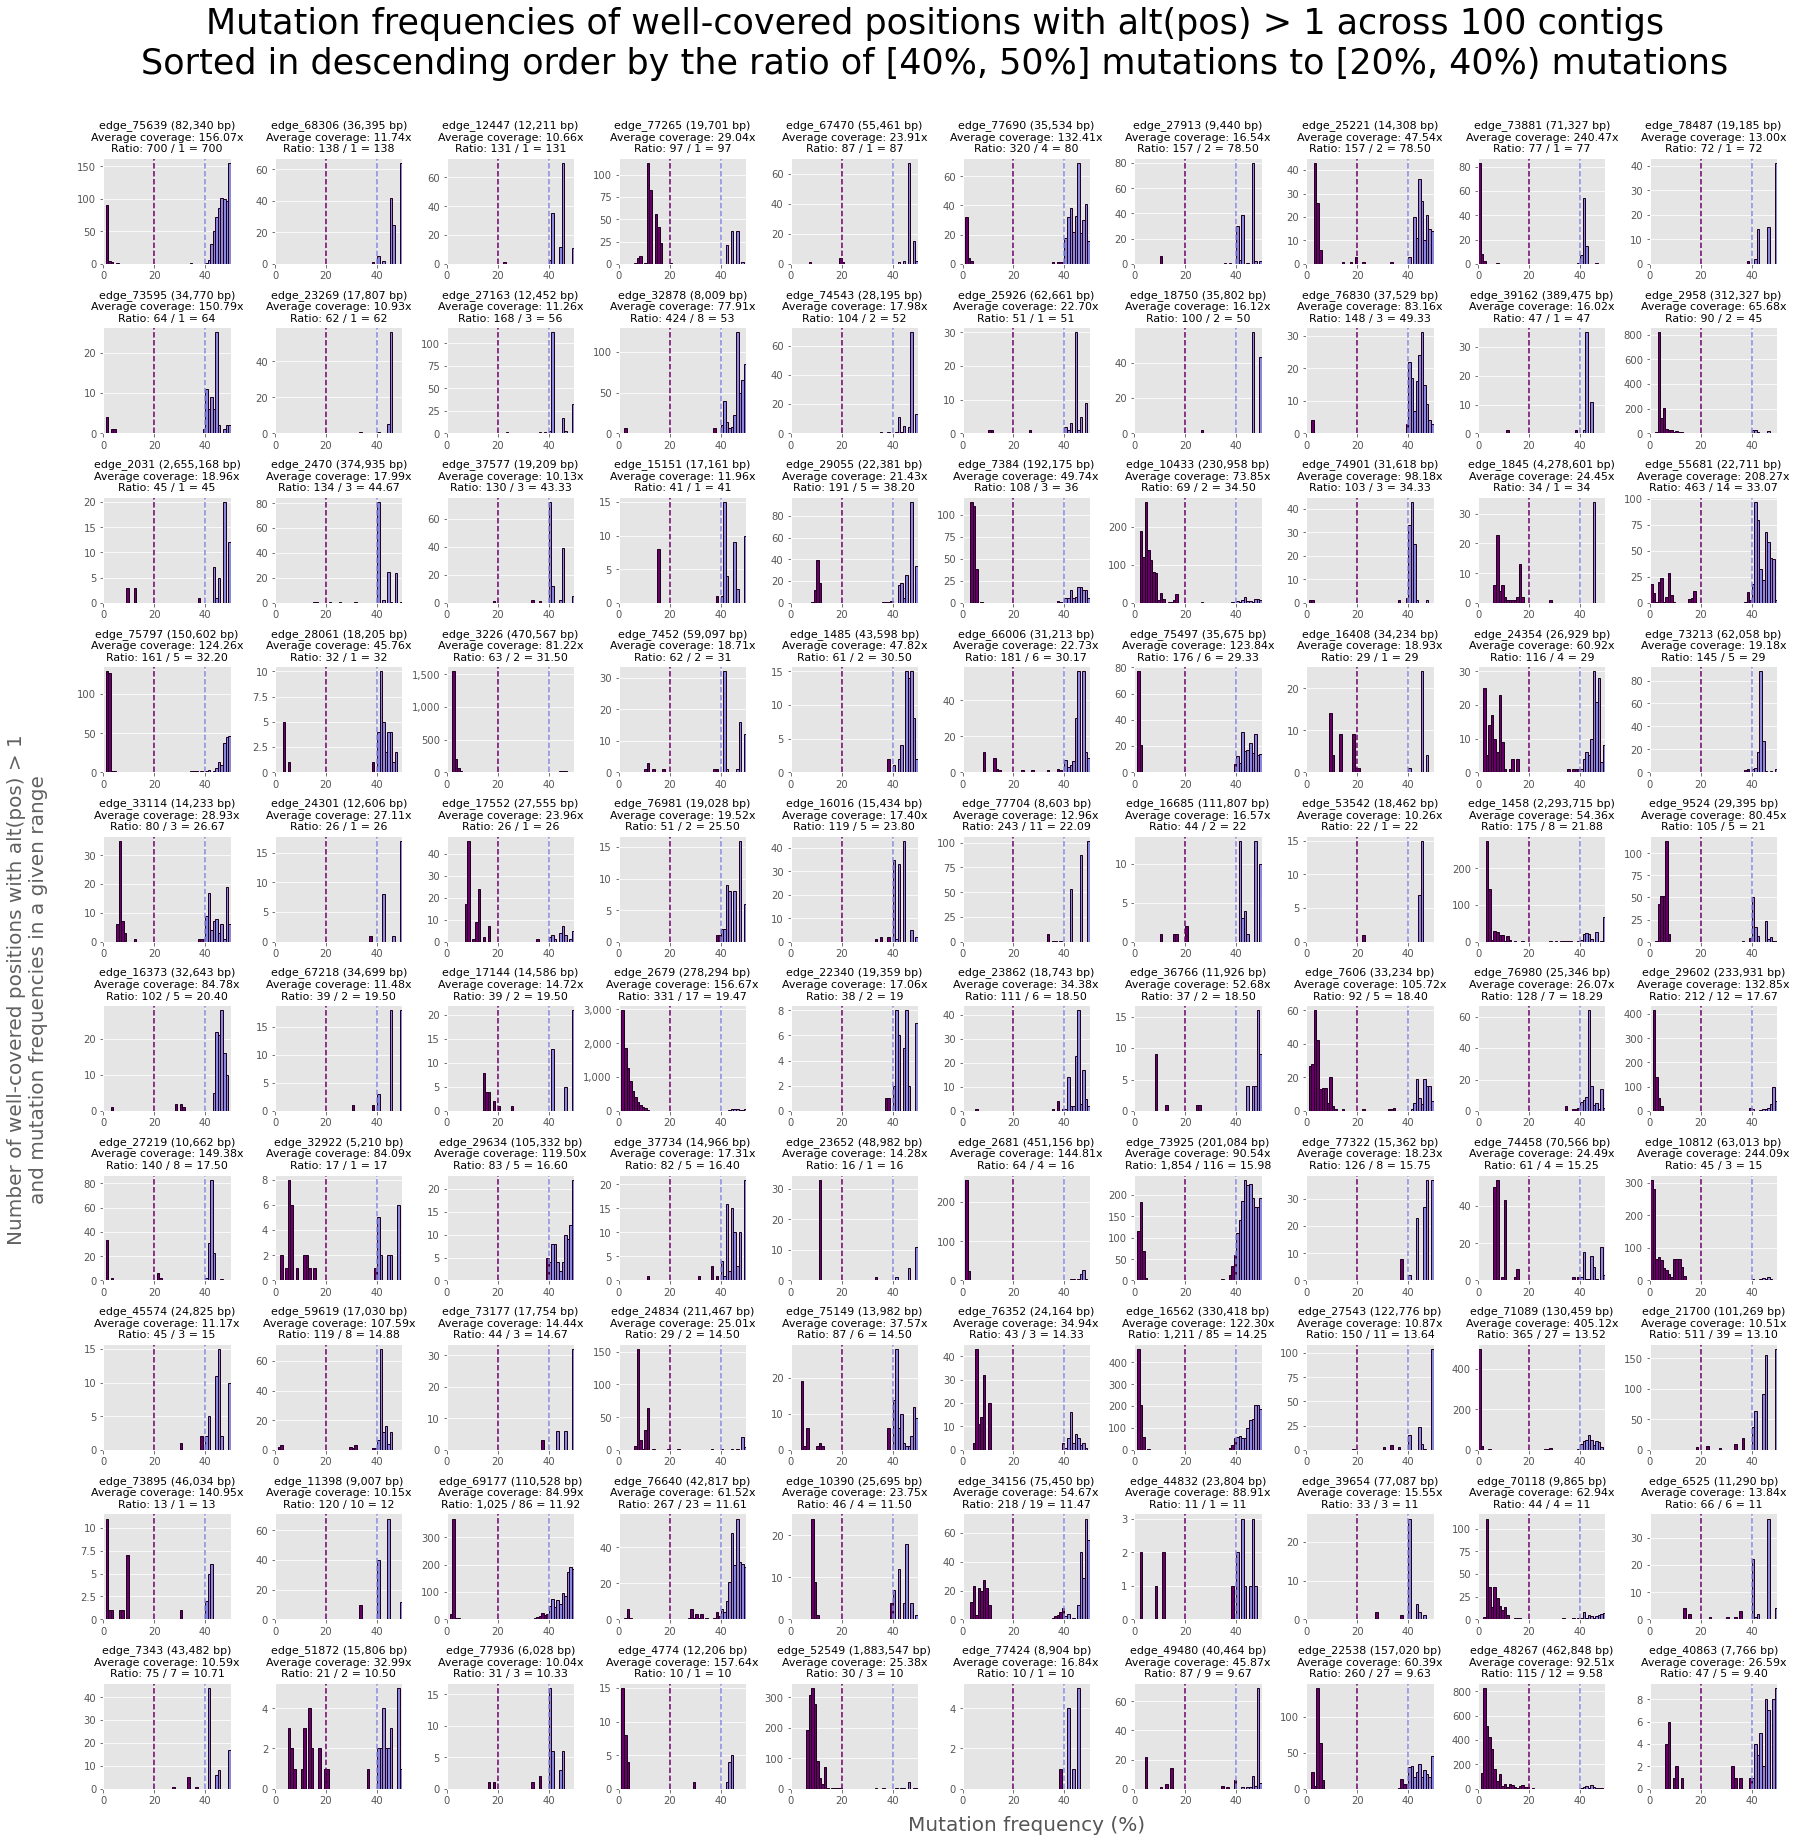

In [107]:
big_mr_plot(sdf, high_ratio_contigs, seq2mincov_pos_mutation_rates_ratiohigh, 10,
            figfilename="40_50_to_20_40_top100.png")

#### Contigs with high fractions of $[40\%, 50\%]$ positions to $[10\%, 50\%]$ positions

... aka the ordinary diploid fraction

In [131]:
df_ordinary = pd.read_csv("../../prok-euk-analyses/output/pleuk_frac_info.tsv", sep="\t", index_col=0)
df_ordinary_f = df_ordinary.loc[df_ordinary["AverageCoverage"] >= 50]
sdf_ordinary = df_ordinary_f.sort_values(by=["DiploidFraction", "NumWellCoveredNumeratorPositions"], ascending=False)
high_ratio_contigs_ordinary = sdf_ordinary.index[:100]

,PotentiallyEukaryotic,AverageCoverage,NumWellCoveredPositions,NumWellCoveredNumeratorPositions,NumWellCoveredDenominatorPositions,DiploidFraction
Contig,,,,,,
edge_78090,True,123.272391,42381,332,332,1.0
edge_40453,True,100.433136,21424,217,217,1.0
edge_36709,True,137.662748,53872,174,174,1.0
edge_76641,True,55.053333,13410,174,174,1.0
edge_78779,True,55.927872,12334,148,148,1.0
...,...,...,...,...,...,...
edge_23926,False,53.605096,107809,0,122,0.0
edge_37602,False,50.684755,18077,0,52,0.0
edge_2919,False,67.231626,94086,0,2,0.0


In [123]:
seq2mincov_pos_mutation_rates_ratiohigh_ordinary = get_seq2mincov_pos_mutation_rates(
    high_ratio_contigs_ordinary
)

Starting process_contig() for contig edge_73925.
Just processed position 100,000 / 201,084 (49.73%).
Just processed position 200,000 / 201,084 (99.46%).
    Average coverage: 90.54x. Meets the mininum of 10.00x.
    Deviation is 20.00%: coverages in the range [72.43x, 108.65x] are WC.
    169,681 / 201,084 (84.38%) positions in this contig are WC.
    1,854 WC numerator pos; 1,974 WC denominator pos.
Computed info for seq edge_73925!
Starting process_contig() for contig edge_16562.
Just processed position 100,000 / 330,418 (30.26%).
Just processed position 200,000 / 330,418 (60.53%).
Just processed position 300,000 / 330,418 (90.79%).
    Average coverage: 122.30x. Meets the mininum of 10.00x.
    Deviation is 20.00%: coverages in the range [97.84x, 146.76x] are WC.
    205,318 / 330,418 (62.14%) positions in this contig are WC.
    1,211 WC numerator pos; 1,296 WC denominator pos.
Computed info for seq edge_16562!
Starting process_contig() for contig edge_69177.
Just processed positio

Just processed position 100,000 / 333,391 (29.99%).
Just processed position 200,000 / 333,391 (59.99%).
Just processed position 300,000 / 333,391 (89.98%).
    Average coverage: 84.04x. Meets the mininum of 10.00x.
    Deviation is 20.00%: coverages in the range [67.23x, 100.85x] are WC.
    212,050 / 333,391 (63.60%) positions in this contig are WC.
    1,878 WC numerator pos; 2,974 WC denominator pos.
Computed info for seq edge_31258!
Starting process_contig() for contig edge_69541.
Just processed position 100,000 / 215,248 (46.46%).
Just processed position 200,000 / 215,248 (92.92%).
    Average coverage: 353.39x. Meets the mininum of 10.00x.
    Deviation is 20.00%: coverages in the range [282.71x, 424.07x] are WC.
    194,406 / 215,248 (90.32%) positions in this contig are WC.
    1,305 WC numerator pos; 2,095 WC denominator pos.
Computed info for seq edge_69541!
Starting process_contig() for contig edge_27070.
Just processed position 100,000 / 1,247,078 (8.02%).
Just processed po

Just processed position 500,000 / 838,385 (59.64%).
Just processed position 600,000 / 838,385 (71.57%).
Just processed position 700,000 / 838,385 (83.49%).
Just processed position 800,000 / 838,385 (95.42%).
    Average coverage: 340.86x. Meets the mininum of 10.00x.
    Deviation is 20.00%: coverages in the range [272.69x, 409.03x] are WC.
    544,718 / 838,385 (64.97%) positions in this contig are WC.
    2,750 WC numerator pos; 5,488 WC denominator pos.
Computed info for seq edge_5133!
Starting process_contig() for contig edge_15277.
Just processed position 100,000 / 386,463 (25.88%).
Just processed position 200,000 / 386,463 (51.75%).
Just processed position 300,000 / 386,463 (77.63%).
    Average coverage: 50.81x. Meets the mininum of 10.00x.
    Deviation is 20.00%: coverages in the range [40.64x, 60.97x] are WC.
    197,462 / 386,463 (51.09%) positions in this contig are WC.
    1,100 WC numerator pos; 2,240 WC denominator pos.
Computed info for seq edge_15277!
Starting process_

Just processed position 300,000 / 368,189 (81.48%).
    Average coverage: 14.60x. Meets the mininum of 10.00x.
    Deviation is 20.00%: coverages in the range [11.68x, 17.52x] are WC.
    153,742 / 368,189 (41.76%) positions in this contig are WC.
    1,344 WC numerator pos; 3,352 WC denominator pos.
Computed info for seq edge_68452!
Starting process_contig() for contig edge_63385.
Just processed position 100,000 / 225,051 (44.43%).
Just processed position 200,000 / 225,051 (88.87%).
    Average coverage: 20.09x. Meets the mininum of 10.00x.
    Deviation is 20.00%: coverages in the range [16.07x, 24.11x] are WC.
    99,327 / 225,051 (44.14%) positions in this contig are WC.
    1,142 WC numerator pos; 2,866 WC denominator pos.
Computed info for seq edge_63385!
Starting process_contig() for contig edge_46852.
Just processed position 100,000 / 179,912 (55.58%).
    Average coverage: 17.36x. Meets the mininum of 10.00x.
    Deviation is 20.00%: coverages in the range [13.89x, 20.84x] are

Just processed position 200,000 / 1,976,500 (10.12%).
Just processed position 300,000 / 1,976,500 (15.18%).
Just processed position 400,000 / 1,976,500 (20.24%).
Just processed position 500,000 / 1,976,500 (25.30%).
Just processed position 600,000 / 1,976,500 (30.36%).
Just processed position 700,000 / 1,976,500 (35.42%).
Just processed position 800,000 / 1,976,500 (40.48%).
Just processed position 900,000 / 1,976,500 (45.54%).
Just processed position 1,000,000 / 1,976,500 (50.59%).
Just processed position 1,100,000 / 1,976,500 (55.65%).
Just processed position 1,200,000 / 1,976,500 (60.71%).
Just processed position 1,300,000 / 1,976,500 (65.77%).
Just processed position 1,400,000 / 1,976,500 (70.83%).
Just processed position 1,500,000 / 1,976,500 (75.89%).
Just processed position 1,600,000 / 1,976,500 (80.95%).
Just processed position 1,700,000 / 1,976,500 (86.01%).
Just processed position 1,800,000 / 1,976,500 (91.07%).
Just processed position 1,900,000 / 1,976,500 (96.13%).
    Aver

Just processed position 100,000 / 481,692 (20.76%).
Just processed position 200,000 / 481,692 (41.52%).
Just processed position 300,000 / 481,692 (62.28%).
Just processed position 400,000 / 481,692 (83.04%).
    Average coverage: 31.42x. Meets the mininum of 10.00x.
    Deviation is 20.00%: coverages in the range [25.13x, 37.70x] are WC.
    158,975 / 481,692 (33.00%) positions in this contig are WC.
    1,336 WC numerator pos; 4,284 WC denominator pos.
Computed info for seq edge_50438!
Starting process_contig() for contig edge_28656.
Just processed position 100,000 / 787,711 (12.70%).
Just processed position 200,000 / 787,711 (25.39%).
Just processed position 300,000 / 787,711 (38.09%).
Just processed position 400,000 / 787,711 (50.78%).
Just processed position 500,000 / 787,711 (63.48%).
Just processed position 600,000 / 787,711 (76.17%).
Just processed position 700,000 / 787,711 (88.87%).
    Average coverage: 34.74x. Meets the mininum of 10.00x.
    Deviation is 20.00%: coverages i

Just processed position 300,000 / 681,628 (44.01%).
Just processed position 400,000 / 681,628 (58.68%).
Just processed position 500,000 / 681,628 (73.35%).
Just processed position 600,000 / 681,628 (88.02%).
    Average coverage: 12.38x. Meets the mininum of 10.00x.
    Deviation is 20.00%: coverages in the range [9.90x, 14.85x] are WC.
    234,724 / 681,628 (34.44%) positions in this contig are WC.
    1,572 WC numerator pos; 5,541 WC denominator pos.
Computed info for seq edge_7997!
Starting process_contig() for contig edge_23113.
Just processed position 100,000 / 326,811 (30.60%).
Just processed position 200,000 / 326,811 (61.20%).
Just processed position 300,000 / 326,811 (91.80%).
    Average coverage: 34.79x. Meets the mininum of 10.00x.
    Deviation is 20.00%: coverages in the range [27.83x, 41.75x] are WC.
    142,280 / 326,811 (43.54%) positions in this contig are WC.
    1,314 WC numerator pos; 4,685 WC denominator pos.
Computed info for seq edge_23113!
Starting process_cont

Just processed position 500,000 / 1,036,260 (48.25%).
Just processed position 600,000 / 1,036,260 (57.90%).
Just processed position 700,000 / 1,036,260 (67.55%).
Just processed position 800,000 / 1,036,260 (77.20%).
Just processed position 900,000 / 1,036,260 (86.85%).
Just processed position 1,000,000 / 1,036,260 (96.50%).
    Average coverage: 12.99x. Meets the mininum of 10.00x.
    Deviation is 20.00%: coverages in the range [10.39x, 15.59x] are WC.
    393,403 / 1,036,260 (37.96%) positions in this contig are WC.
    1,953 WC numerator pos; 7,859 WC denominator pos.
Computed info for seq edge_5394!
Starting process_contig() for contig edge_10333.
Just processed position 100,000 / 239,391 (41.77%).
Just processed position 200,000 / 239,391 (83.55%).
    Average coverage: 21.82x. Meets the mininum of 10.00x.
    Deviation is 20.00%: coverages in the range [17.46x, 26.19x] are WC.
    154,680 / 239,391 (64.61%) positions in this contig are WC.
    1,192 WC numerator pos; 4,815 WC den

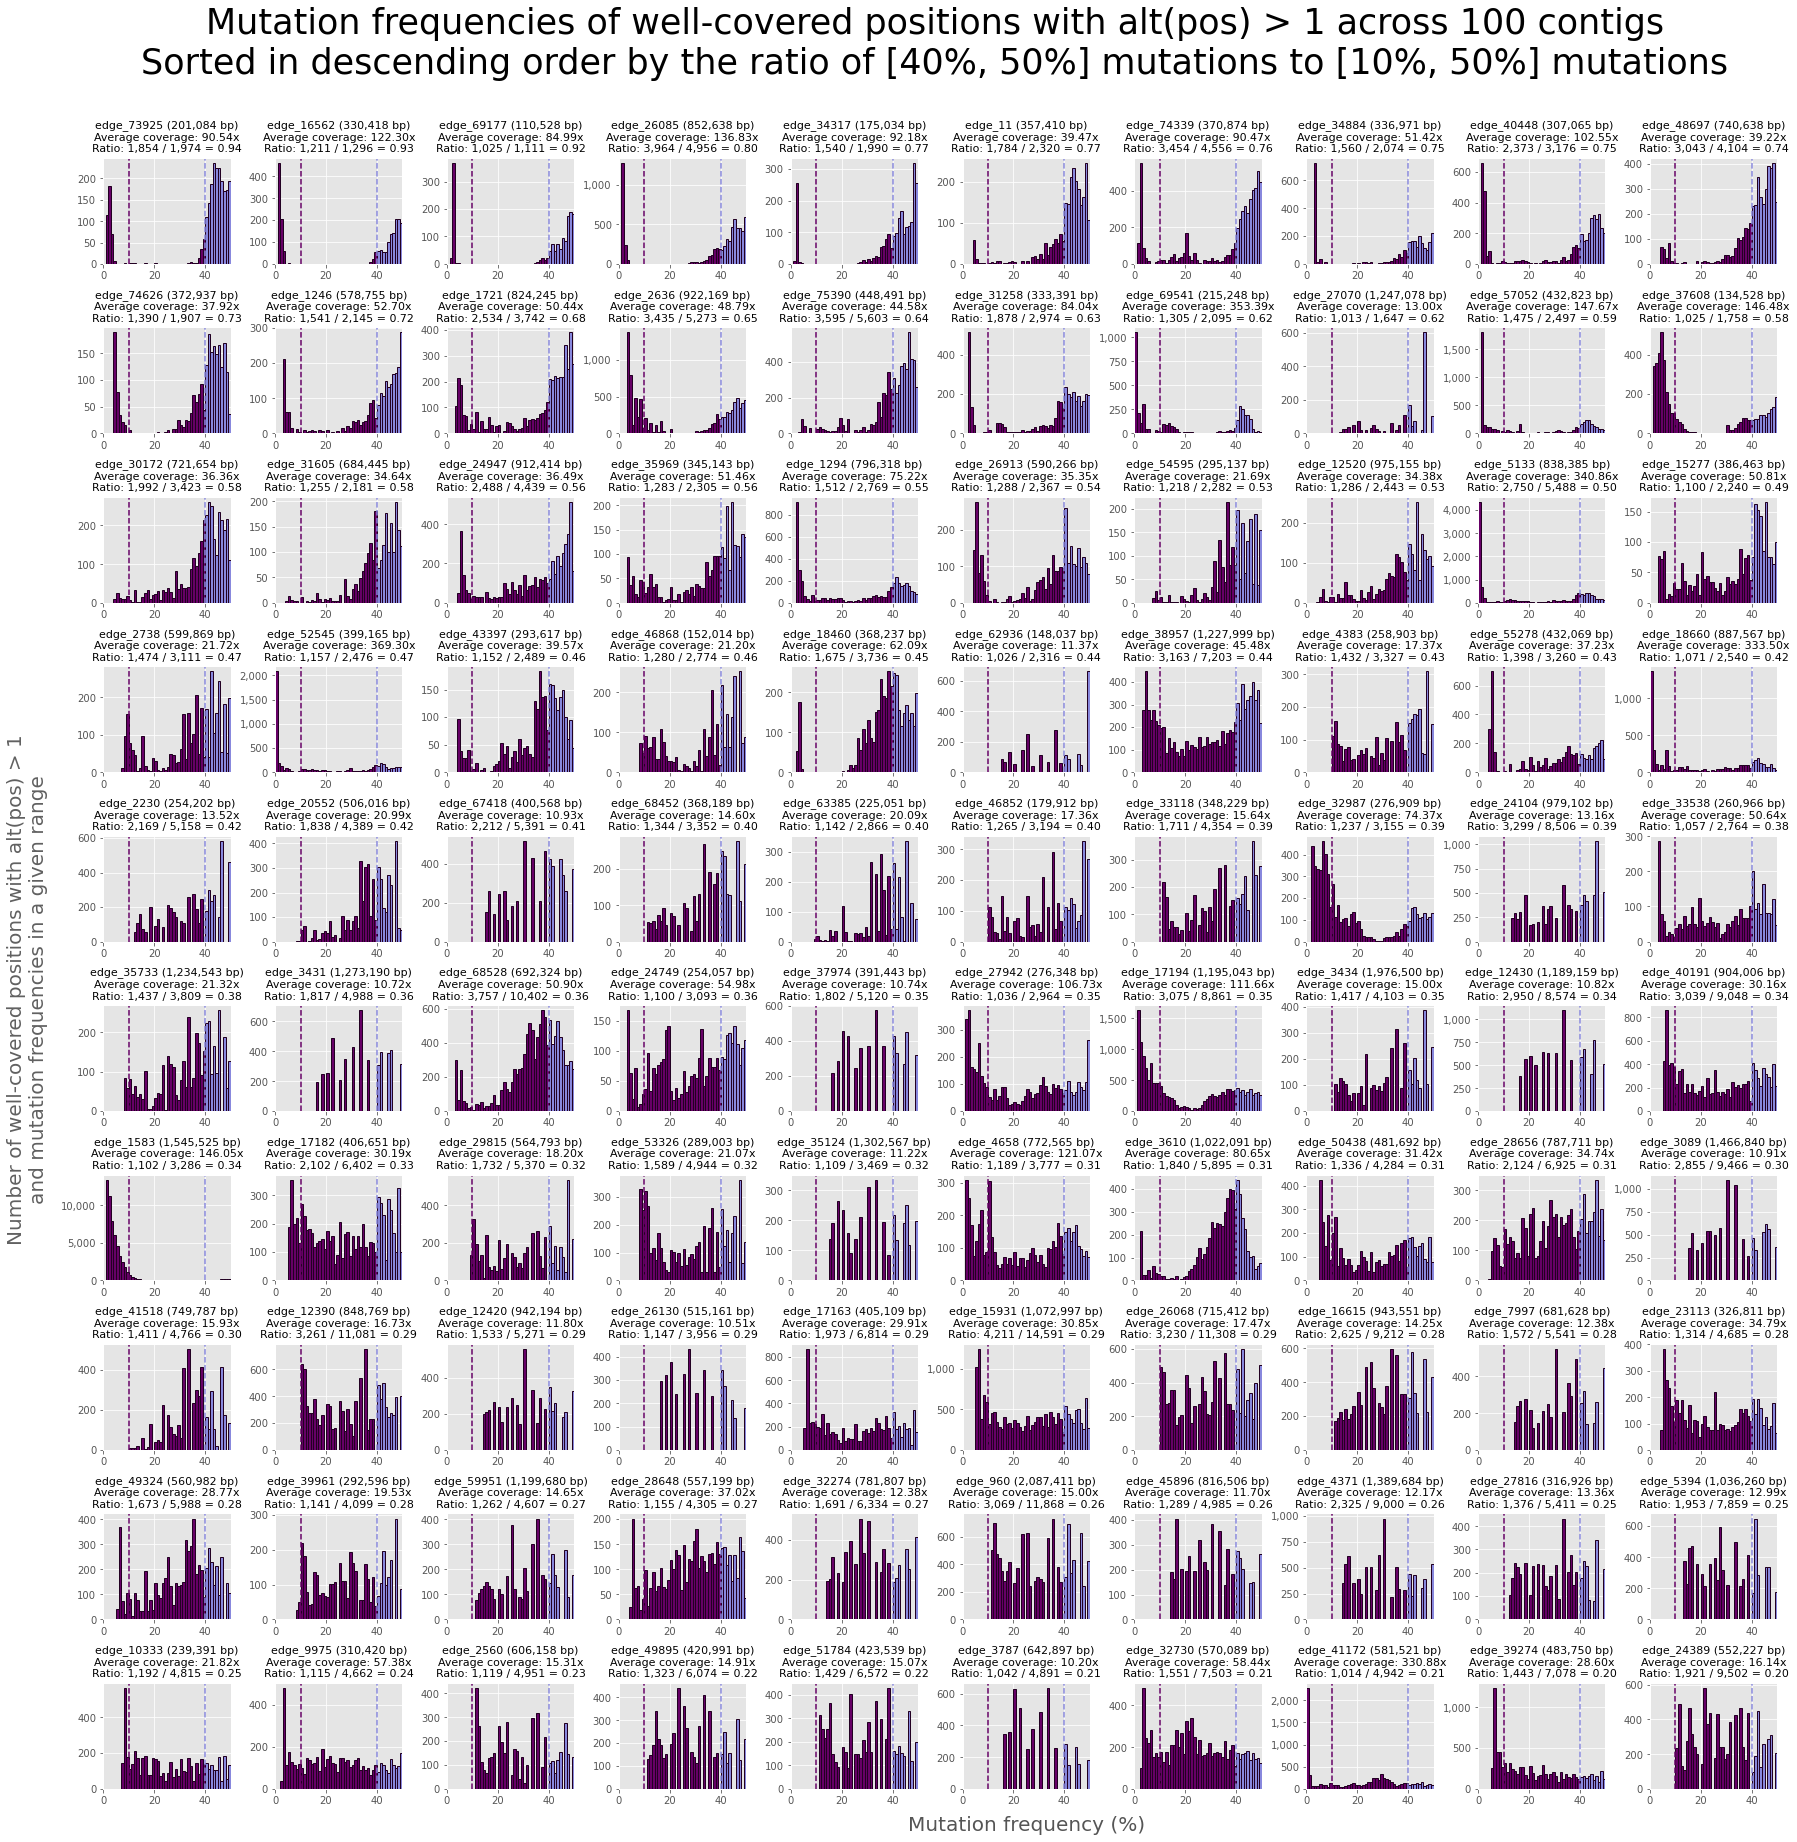

In [124]:
big_mr_plot(sdf_ordinary, high_ratio_contigs_ordinary, seq2mincov_pos_mutation_rates_ratiohigh_ordinary, 10,
            x2vlinecolor={10: "#660066", 40: "#8888dd"},
            den_range="[10%, 50%]",
            figfilename="40_50_to_10_50_top100.png")

## Visualize diploid fractions

In [13]:
# we already filtered h_mut_rates_alt_gt_min to positions with alt(pos) > 1 so we can just look at rel frequencies
human_diploid_ct = len([m for m in h_mut_rates_alt_gt_min if m >= MIN_DIPLOID_MAXALT_RELFREQ])
human_denominator_ct = len([m for m in h_mut_rates_alt_gt_min if m >= MIN_DENOMINATOR_MAXALT_RELFREQ])
hfrac = human_diploid_ct / human_denominator_ct
print(f"Human diploid fraction: {100 * hfrac:.2f}%")
print(f"Number of diploid positions: {human_diploid_ct:,}")
print(f"Number of denominator positions: {human_denominator_ct:,}")

Human diploid fraction: 49.22%
Number of diploid positions: 50,336
Number of denominator positions: 102,274


In [128]:
def dfplot_sheepgut_contigs(min_denominator_val, use_symlog=True, figfilename=None, exclude_fracs_below=None):
    
    if min_denominator_val < 0:
        raise ValueError("Min denominator val has to be at least 0, otherwise we get division by 0 errors...")
    
    e2frac = {}
    for e in edge2num_wc_den_pos:
        if edge2num_wc_den_pos[e] > min_denominator_val:
            f = edge2num_wc_diploid_pos[e] / edge2num_wc_den_pos[e]
            if exclude_fracs_below is None or f >= exclude_fracs_below:
                e2frac[e] = f
    
    # We explicilty use the unicode character for the hyphen to prevent LaTeX from treating it as a
    # minus symbol. This is a bit harder to handle simply in matplotlib-using-LaTeX than it is in just
    # vanilla LaTeX. Idea to use unicode chars c/o https://stackoverflow.com/a/30201951 (although I used
    # a different unicode character).
    prefix = r"Number\ of\ well" + u"\u2010" + r"covered\ positions\ with\ mutation\ frequencies\ \geq "
    denclause = ",\naverage coverage $\geq$ 10x, "
    dvc = f"a denominator > {min_denominator_val:,}"
    if exclude_fracs_below is None:
        denclause += f"and {dvc}"
    else:
        denclause += f"{dvc}, and fractions $\geq$ {exclude_fracs_below * 100:.0f}%"
    
    fracplot(
        e2frac,
        prefix + "40\%\ and\ alt(pos)\ > 1",
        prefix + "10\%\ and\ alt(pos)\ > 1",
        denclause=denclause,
        figfilename=figfilename,
        use_symlog=use_symlog,
        #vlines=[(hfrac, "Human genome contig (interior region)")]
    )

In [133]:
def dfplot_human_blocks(min_denominator_val, use_symlog=True, figfilename=None, exclude_fracs_below=None):
    # NOTE THAT min_denominator_val is not included, so i guess it should be + 1 or something in the future
    
    if min_denominator_val < 0:
        raise ValueError("Min denominator val has to be at least 0, otherwise we get division by 0 errors...")

    b2frac = {}
    for i in range(inner_block_start_idx, inner_block_end_idx):
        if human_contig_results["num_wc_denominator_pos"][i] > min_denominator_val:
            f = human_contig_results["num_wc_numerator_pos"][i] / human_contig_results["num_wc_denominator_pos"][i]
            if exclude_fracs_below is None or f >= exclude_fracs_below:
                b2frac[i] = f
                
    # This code is reused with the other dfplot_ method... try to limit reuse if easily possible
    prefix = r"Number\ of\ well" + u"\u2010" + r"covered\ positions\ with\ mutation\ frequencies\ \geq "
    denclause = " "
    dvc = f"a denominator > {min_denominator_val:,}"
    if exclude_fracs_below is None:
        denclause += f"and {dvc}"
    else:
        denclause += f"{dvc}, and fractions $\geq$ {exclude_fracs_below * 100:.0f}%"
    
    fracplot(
        b2frac,
        prefix + "40\%\ and\ alt(pos)\ > 1",
        prefix + "10\%\ and\ alt(pos)\ > 1",
        noun="human genome contig blocks\nof length 50,000 bp",
        ylabel="Number of blocks with fractions in a range",
        denclause=denclause,
        figfilename=figfilename,
        use_symlog=use_symlog,
    )

### All contigs with a nonzero denominator

8,523 edges represented in this edge2frac object.
Max frac: 100.0 (edge edge_78793); min frac: 0.0 (edge edge_3)
Top 10 edges: ['edge_77463', 'edge_77680', 'edge_77713', 'edge_77866', 'edge_78010', 'edge_78042', 'edge_78090', 'edge_78642', 'edge_78779', 'edge_78793']
Bottom 10 edges: ['edge_3', 'edge_8', 'edge_17', 'edge_35', 'edge_37', 'edge_67', 'edge_72', 'edge_79', 'edge_81', 'edge_106']


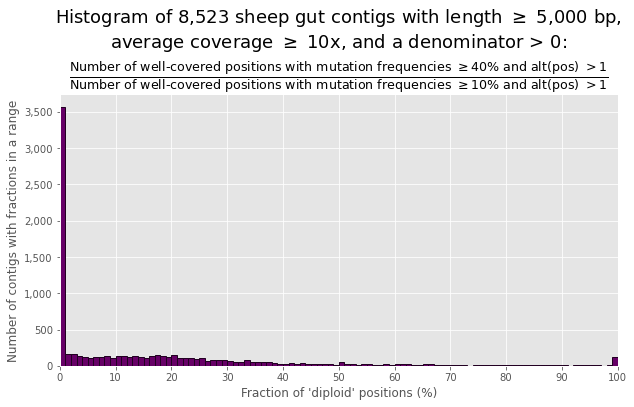

In [137]:
dfplot_sheepgut_contigs(0, use_symlog=False, figfilename="prokeukfrac_minden0_nonlog.png")

3,770 edges represented in this edge2frac object.
Max frac: 100.0 (edge edge_78779); min frac: 1.015625 (edge edge_72658)
Top 10 edges: ['edge_75639', 'edge_17625', 'edge_18152', 'edge_20930', 'edge_36709', 'edge_40453', 'edge_74960', 'edge_76641', 'edge_78090', 'edge_78779']
Bottom 10 edges: ['edge_72658', 'edge_3158', 'edge_78631', 'edge_127', 'edge_13654', 'edge_76545', 'edge_28448', 'edge_63723', 'edge_3778', 'edge_22932']


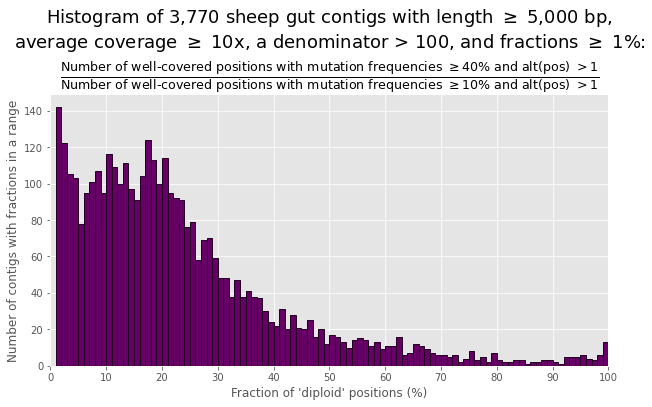

In [129]:
dfplot_sheepgut_contigs(100, use_symlog=False, exclude_fracs_below=0.01, figfilename="prokeukfrac_minden100_fgeq1.png")

8,523 edges represented in this edge2frac object.
Max frac: 100.0 (edge edge_78793); min frac: 0.0 (edge edge_3)
Top 10 edges: ['edge_77463', 'edge_77680', 'edge_77713', 'edge_77866', 'edge_78010', 'edge_78042', 'edge_78090', 'edge_78642', 'edge_78779', 'edge_78793']
Bottom 10 edges: ['edge_3', 'edge_8', 'edge_17', 'edge_35', 'edge_37', 'edge_67', 'edge_72', 'edge_79', 'edge_81', 'edge_106']
5,226 edges represented in this edge2frac object.
Max frac: 100.0 (edge edge_78779); min frac: 0.0 (edge edge_3)
Top 10 edges: ['edge_75639', 'edge_17625', 'edge_18152', 'edge_20930', 'edge_36709', 'edge_40453', 'edge_74960', 'edge_76641', 'edge_78090', 'edge_78779']
Bottom 10 edges: ['edge_3', 'edge_8', 'edge_17', 'edge_35', 'edge_37', 'edge_79', 'edge_106', 'edge_120', 'edge_430', 'edge_471']


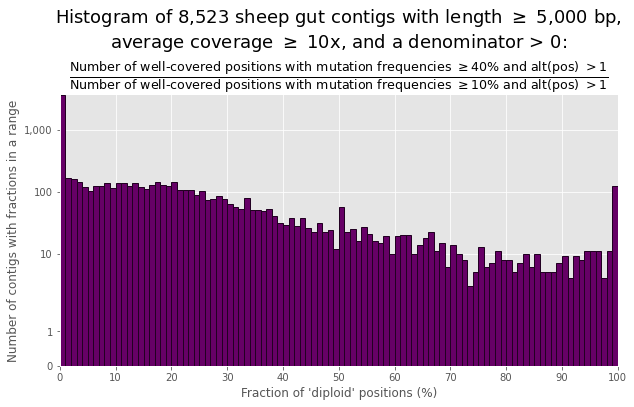

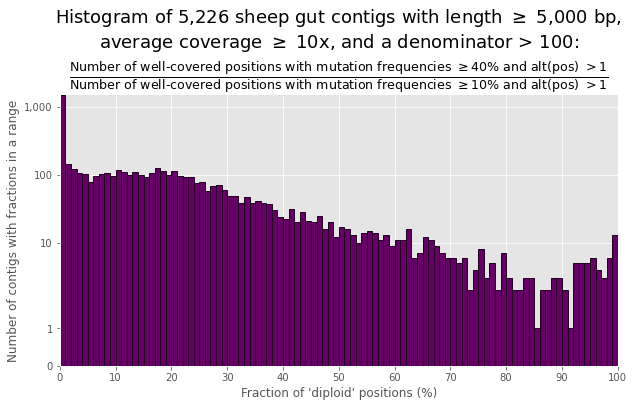

In [113]:
for minden in (0, 100):
    dfplot_sheepgut_contigs(minden, use_symlog=True, figfilename=f"prokeukfrac_minden{minden}.png")

1,910 edges represented in this edge2frac object.
Max frac: 100.0 (edge 1993); min frac: 0.0 (edge 21)
Top 10 edges: [1932, 1934, 1935, 1937, 1953, 1955, 1956, 1970, 1980, 1993]
Bottom 10 edges: [21, 22, 26, 28, 35, 38, 86, 126, 150, 177]
392 edges represented in this edge2frac object.
Max frac: 100.0 (edge 1572); min frac: 0.0 (edge 26)
Top 10 edges: [371, 508, 554, 720, 980, 1066, 1095, 1127, 1430, 1572]
Bottom 10 edges: [26, 38, 126, 968, 1566, 1415, 1905, 815, 432, 1132]
84 edges represented in this edge2frac object.
Max frac: 100.0 (edge 1095); min frac: 0.0 (edge 968)
Top 10 edges: [408, 142, 1568, 1632, 1292, 1574, 133, 154, 720, 1095]
Bottom 10 edges: [968, 1566, 1415, 1905, 815, 432, 1132, 575, 777, 1785]
36 edges represented in this edge2frac object.
Max frac: 97.6608187134503 (edge 1574); min frac: 0.0 (edge 968)
Top 10 edges: [1994, 604, 901, 792, 1573, 1496, 218, 2000, 1292, 1574]
Bottom 10 edges: [968, 1566, 1415, 1905, 1132, 1785, 332, 1614, 415, 557]


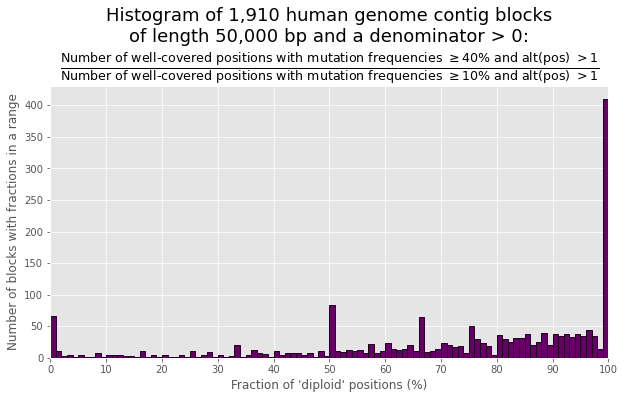

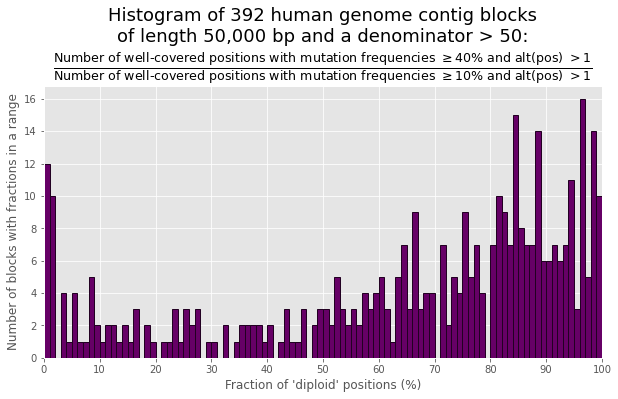

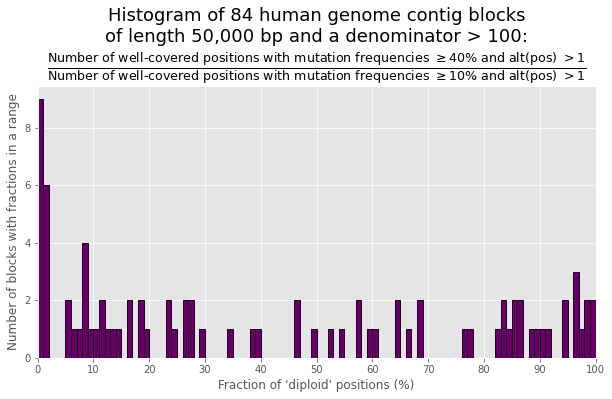

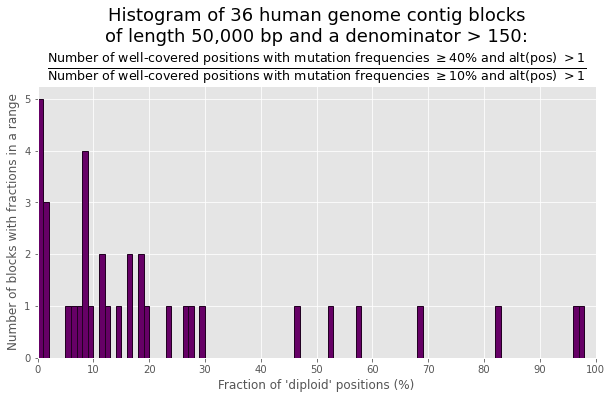

In [142]:
for minden in (0, 50, 100, 150):
    dfplot_human_blocks(minden, use_symlog=False, figfilename=f"prokeukfrac_humandiploidfractions_minden{minden}.png")

In [66]:
def estats(e):
    num_dip = edge2num_wc_diploid_pos[e]
    num_den = edge2num_wc_den_pos[e]
    num_mcp = edge2num_wc_pos[e]
    print(f"{e} ({edge2len[e]:,} bp long, {edge2meancov[e]:,.2f}x avg cov) has", end=" ")
    print(f"{num_mcp:,} WC pos.", end=" ")
    print(f"{num_dip:,} WC 'diploid' pos.", end=" ")
    print(f"{num_den:,} WC 'denominator' pos.")
    #if e in e2frac:
    #    print(f"\tDiploid fraction: {e2frac[e] * 100:.2f}%")
    #else:
    #    print("\tDiploid fraction undefined for this edge.")

In [74]:
estats("edge_78793")
estats("edge_5763")
estats("edge_78779")
estats("edge_26085")
estats("edge_38957")
estats("edge_32274")
estats("edge_4371")

edge_78793 (39,434 bp long, 29.65x avg cov) has 34,412 WC pos. 2 WC 'diploid' pos. 2 WC 'denominator' pos.
edge_5763 (1,729,270 bp long, 32.51x avg cov) has 1,436,967 WC pos. 0 WC 'diploid' pos. 6,084 WC 'denominator' pos.
edge_78779 (12,353 bp long, 55.93x avg cov) has 12,334 WC pos. 148 WC 'diploid' pos. 148 WC 'denominator' pos.
edge_26085 (852,638 bp long, 136.91x avg cov) has 711,925 WC pos. 4,426 WC 'diploid' pos. 5,496 WC 'denominator' pos.
edge_38957 (1,227,999 bp long, 45.63x avg cov) has 942,208 WC pos. 4,759 WC 'diploid' pos. 10,613 WC 'denominator' pos.
edge_32274 (781,807 bp long, 12.38x avg cov) has 512,885 WC pos. 5,553 WC 'diploid' pos. 17,578 WC 'denominator' pos.
edge_4371 (1,389,684 bp long, 12.17x avg cov) has 908,029 WC pos. 6,766 WC 'diploid' pos. 20,620 WC 'denominator' pos.
